In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using ClusterValidityIndices
using MultivariateStats

using PyCall

phate = pyimport("phate")

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

# df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

# df_current = filter(:n_traj=>x->x==2500,df);

# evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

Dict{String, Any} with 6 entries:
  "bistable"     => NaN
  "feed_forward" => [0.0 0.0 0.0 0.19495; 0.173532 0.0 0.0 0.0; 3.02262 -5.5322…
  "classical"    => [0.0 0.0 0.0 0.114353; -0.560775 0.359711 0.0 0.0; -0.07258…
  "frozen_osc"   => NaN
  "mutual_inh"   => [0.0 0.0 0.0 0.2454; 0.455819 0.0 -2.23319 0.0; 0.446651 -2…
  "overlap_dom"  => [0.0 0.0 -0.00379469 0.228214; 0.653415 0.0 0.0 0.0; -0.424…

In [3]:
save_t = false

false

In [4]:
run_data = load(datadir("sims/repeated_evolution_different_topologies/max_gen=20000_mutation_method=all_viable_n_traj=20000_noise_cv=1.0_noise_method=additive_start_network_name=c100_w40_topology=overlap_dom_β=Inf.jld2"))["raw_data"];

In [5]:
function refresh_type(v)
    [i for i in v]
end

function attach_column_to_tuples(column::Vector{Float64},tuples::Vector{Tuple{Float64,Float64}})
    return hcat(column,hcat(first.(tuples), last.(tuples)))
end

function tuples_to_matrix(tuples::Vector{Tuple{Float64,Float64}})
    return hcat(first.(tuples), last.(tuples))
end


function pairwise_frechet(metric::PreMetric,X)

    result = zeros(length(X),length(X))

    for j in 1:size(result,2)
        for i in 1:size(result,1)
            if i < j
                result[i,j] = 1.
            end
        end
    end

    choices = Tuple.(findall(x->x>0,result))

    for entry in choices
        result[entry...] = frechet(metric,X[entry[1]],X[entry[2]])
    end

    return Symmetric(result) |> collect

end

function frechet(metric::PreMetric, P::AbstractMatrix, Q::AbstractMatrix)
    dP, m = size(P)
    dQ, n = size(Q)

    dP != dQ && throw(DimensionMismatch(
        "Points in polygonal lines P and Q must have the same dimension."))

    couplings = pairwise(metric, P, Q, dims=2)

    @inbounds for i in 2:m
        couplings[i, 1] = max(couplings[i-1, 1], couplings[i, 1])
    end

    @inbounds for j in 2:n
        couplings[1, j] = max(couplings[1, j-1], couplings[1, j])
        for i in 2:m
            carried_coupling = min(couplings[i-1, j-1],
                                   couplings[i, j-1],
                                   couplings[i-1, j])
            couplings[i, j] = max(carried_coupling, couplings[i, j])
        end
    end

    return couplings[m, n]
end


frechet (generic function with 1 method)

In [6]:
mutable struct PhenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    pheno_traj :: Vector{Vector{Tuple{Float64, Float64}}}
    traj_m ::Vector{Matrix{Float64}}
    initial_fitness :: Float64
    initial_phenotype :: Tuple{Float64,Float64}

    full_pheno_traj :: Union{Vector{Vector{Tuple{Float64, Float64}}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fpt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}
    
    debug ::Any
end

mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Matrix{Float64}}}

    geno_traj :: Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fgt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}

    debug ::Any
end

function PhenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[2],et.fitness_trajectory)),evo_traces)
    pheno_traj = map(et->refresh_type(reduce(vcat,et.traversed_phenotypes)),evo_traces)

    traj_m = map(x->tuples_to_matrix(x) |> transpose |> collect,pheno_traj);

    initial_fitness = fitness_traj[1][1]
    initial_phenotype = pheno_traj[1][1]

    if initial_fitness < 0
        PhenoTrajectories(fitness_traj,pheno_traj,traj_m,initial_fitness, initial_phenotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        PhenoTrajectories(fitness_traj,pheno_traj,traj_m,-initial_fitness, initial_phenotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    end

end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[2],et.fitness_trajectory)),evo_traces)
    geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

    traj = map(et->unique(et.traversed_topologies),evo_traces);

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    if initial_fitness < 0
        GenoTrajectories(fitness_traj,traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    else
        fitness_traj = map(x-> -1 .* x,fitness_traj)
        GenoTrajectories(fitness_traj,traj,geno_traj,-initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)
    end
end


GenoTrajectories

In [7]:
function interpolate_pheno_trajectories_by_fitness!(pt::PhenoTrajectories,n::Int64)

    full_pheno_traj = []

    for i in 1:length(pt.fitness_traj)
        unique_pheno_visits = unique(attach_column_to_tuples(unique(pt.fitness_traj[i]),pt.pheno_traj[i]), dims = 1)
        fitness_timestamps = unique_pheno_visits[:,1]
        itp_c = DataInterpolations.LinearInterpolation(unique_pheno_visits[:,2],fitness_timestamps);
        itp_w = DataInterpolations.LinearInterpolation(unique_pheno_visits[:,3],fitness_timestamps);
        fpt = [(itp_c(t),itp_w(t)) for t in pt.initial_fitness:n:0]
        push!(full_pheno_traj,fpt)
    end

    fpt_mat = map(x->tuples_to_matrix(x),full_pheno_traj)

    all_c = reduce(hcat,map(p->p[:,1],fpt_mat))
    all_w = reduce(hcat,map(p->p[:,2],fpt_mat))

    fpt_data = vcat(all_c,all_w);

    pt.full_pheno_traj = full_pheno_traj;
    pt.fpt_data = fpt_data
end


function cluster_pheno_trajectories_kmeans!(pt::PhenoTrajectories,n_clusters::Int64,metric = SqEuclidean())

    R = kmeans(pt.fpt_data,n_clusters,distance = metric)

    pt.cluster_assignments = assignments(R);
    
end

function cluster_pheno_trajectories_kmeans(pt::PhenoTrajectories,n_clusters::Int64,metric = SqEuclidean())

    R = kmeans(pt.fpt_data,n_clusters,distance = metric)

    return assignments(R);
    
end


function determine_optimal_clusters_databased!(pt::PhenoTrajectories,max_clusters::Int64,cluster_validity_index = CH(),cluster_metric = SqEuclidean())

    km_range = 2:max_clusters
    
    criterion_values = zeros(length(km_range))
    
    for (i, n_clust) = enumerate(km_range)
    
        assignments = cluster_pheno_trajectories_kmeans(pt,n_clust,cluster_metric);
    
        cv = get_cvi!(cluster_validity_index, pt.fpt_data, assignments)

        if cv > maximum(criterion_values)
            pt.cluster_assignments = assignments
            pt.optimal_n_cluster = n_clust
        end

        criterion_values[i] = cv
    end

    # pt.optimal_n_cluster = km_range[argmax(criterion_values)]
    pt.max_clusters = max_clusters
    pt.criterion_values = criterion_values
    
end

function determine_optimal_clusters_distancebased!(pt::PhenoTrajectories,max_clusters::Int64,cluster_metric = SqEuclidean())

    km_range = 2:max_clusters
    
    criterion_values = zeros(length(km_range))

    pt.distance_mat = pairwise(SqEuclidean(),pt.fpt_data)
    
    for (i, n_clust) = enumerate(km_range)
    
        assignments = cluster_pheno_trajectories_kmeans(pt,n_clust,cluster_metric);

        mi = mean(silhouettes(assignments, pt.distance_mat))

        if mi > maximum(criterion_values)
            pt.cluster_assignments = assignments
            pt.optimal_n_cluster = n_clust
        end

        criterion_values[i] = mi
    end

    pt.optimal_n_cluster = km_range[argmax(criterion_values)]
    pt.max_clusters = max_clusters
    pt.criterion_values = criterion_values
end

function return_arrows(traj::Vector{Tuple{Float64,Float64}})

    traj_m = tuples_to_matrix(traj)

    all_diff_x = []
    all_diff_y = []

    x_s = []
    y_s = []

    for di in 1:size(traj_m,1)-1
        diff_x = traj_m[di+1,1] - traj_m[di,1]
        diff_y = traj_m[di+1,2] - traj_m[di,2]
        push!(all_diff_x,diff_x)
        push!(all_diff_y,diff_y)
        push!(x_s,traj_m[di,1])
        push!(y_s,traj_m[di,2])

    end

    return x_s, y_s, all_diff_x,all_diff_y
end

function cluster_density(pt :: Union{PhenoTrajectories,GenoTrajectories}, n_clusters::Int64)

    cm = countmap(pt.cluster_assignments)
    result = zeros(n_clusters)
    for cl in 1:n_clusters
        result[cl] = cm[cl] / length(pt.cluster_assignments)
    end
    return result
end



cluster_density (generic function with 1 method)

In [8]:
function plot_methodology_pheno_traj(pt::PhenoTrajectories, sample_choices::Vector{Int64}, topology_name::String, target = (40,20))

    fig = CairoMakie.Figure(resolution = (2000, 800),fontsize = 27.)

    # sample_choices = [12,8]
    # sample_choices = [2,82]
    
    color_choices = [:red, :blue]

    # Contour plot

    xmin, x_max = (0,120)
    ymin, y_max = (0,120)

    c = LinRange(xmin, x_max, 200)
    w = LinRange(ymin, y_max, 200)

    z = -1 .* ( (c' .- target[1]).^2 .+ (w .- target[2]).^2 )

    gl = fig[1,1]

    ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)", title = "Example phenotype trajectories for " * topology_name * " topology")

    c = CairoMakie.contourf!(ax1,c,w,transpose(z),levels = 10)

    path_n = 1

    for (sample_id,cc) in zip(sample_choices,color_choices)
        CairoMakie.scatter!(ax1,unique(pt.pheno_traj[sample_id]), label = "Trajectory " * string(path_n),markersize = 15., marker = :x,color = cc)
        CairoMakie.arrows!(ax1,return_arrows(unique(pt.pheno_traj[sample_id]))...,arrowsize  = 8.)

        path_n +=1
    end

    CairoMakie.scatter!(ax1,target,markersize = 20., marker = :●,label = "Target Phenotype", color = :purple)

    CairoMakie.axislegend()

    Colorbar(gl[1,2], c)

    # Comparison chart

    gr = fig[1,2]

    ax3  = Axis(gr[1,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Centre position (cell id)", title = "Trajectory comparison - stripe center")
    ax4  = Axis(gr[2,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Stripe width (cells)", title = "Trajectory comparison - stripe width")

    path_n = 1

    for (sample_id,cc) in zip(sample_choices,color_choices)

        data = unique(attach_column_to_tuples(unique(pt.fitness_traj[sample_id]),pt.pheno_traj[sample_id]),dims = 1)

        c_d = [ fc for fc in zip(data[:,1],data[:,2])]
        w_d = [ fw for fw in zip(data[:,1],data[:,3])]
        
        CairoMakie.scatter!(ax3,c_d, color = cc, label = "Trajectory " * string(path_n))
        CairoMakie.scatter!(ax4,w_d, color = cc, label = "Trajectory " * string(path_n))
        
        CairoMakie.lines!(ax3,c_d,color = cc,label = "Trajectory " * string(path_n) * " (Interpolation)")
        CairoMakie.lines!(ax4,w_d,color = cc,label = "Trajectory " * string(path_n) * " (Interpolation)")

        path_n +=1
    end

    # CairoMakie.axislegend(position = :cb)

    leg = Legend(fig[1,3],ax3)

    fig
end


function plot_clustered_pheno_traj(pt::PhenoTrajectories, n_clusters::Int64, topology_name::String, target = (40,20))

    # cluster_pheno_trajectories!(pt,n_clusters,SqEuclidean());

    fig = CairoMakie.Figure(resolution = (1600, 800),fontsize = 27.)

    color_scheme = palette(:tab10)

    # Contour plot

    xmin, x_max = (0,120)
    ymin, y_max = (0,120)

    c = LinRange(xmin, x_max, 200)
    w = LinRange(ymin, y_max, 200)

    z = -1 .* ( (c' .- target[1]).^2 .+ (w .- target[2]).^2 )

    gl = fig[1,1]

    # ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)", title = "Clustered phenotype trajectories for " * topology_name * " topology; n_clusters = " * string(n_clusters) * ", n_samples = " * string(length(pt.fitness_traj)))
    ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)", title = "Clustered phenotype trajectories for " * topology_name * " topology" )

    c = CairoMakie.contourf!(ax1,c,w,transpose(z),levels = 10)

    for cl in 1:n_clusters

        cluster_traj = pt.full_pheno_traj[findall(x->x==cl, pt.cluster_assignments)]

        freq = length(findall(x->x==cl, pt.cluster_assignments))/length(pt.cluster_assignments)

        cluster_traj_m = map(x->tuples_to_matrix(x),cluster_traj)

        mc = mean(reduce(hcat,map(p->p[:,1],cluster_traj_m)),dims = 2)
        mw = mean(reduce(hcat,map(p->p[:,2],cluster_traj_m)),dims = 2)

        mean_traj = hcat(mc,mw)

        mean_traj_tuples = mapslices(x->(x[1],x[2]),mean_traj,dims = 2)[:,1]

        CairoMakie.lines!(ax1,mean_traj_tuples, label = "Cluster " * string(cl) * " Trajectories",linewidth = 6.,color = color_scheme[cl])
    end

    CairoMakie.scatter!(ax1,target,markersize = 20., marker = :●,label = "Target Phenotype", color = :purple)

    CairoMakie.axislegend()

    Colorbar(gl[1,2], c)

    # Barplot

    cd = cluster_density(pt, n_clusters)

    ocd_labels = sortperm(cd)

    ocd = cd[ocd_labels]

    gr = fig[1,2]

    ax2  = Axis(gr, backgroundcolor = "white", xlabel = "Cluster", ylabel = "Frequency",xticklabelsvisible=false,title = "Cluster association frequency")

    CairoMakie.barplot!(ax2,ocd, color = color_scheme[ocd_labels])

    ax2.xticks = ocd_labels

    return fig
end

plot_clustered_pheno_traj (generic function with 2 methods)

In [9]:
# topology = "overlap_dom"

# start_network = example_networks[topology]
# run_data = evolutionary_runs[topology];

evo_traces = map(x->x[2],run_data);

In [10]:
pt = PhenoTrajectories(evo_traces);

interpolate_pheno_trajectories_by_fitness!(pt,10);

In [11]:
# hc = hclust(pt.distance_mat,linkage = :ward)

# max_cluster = 8

# range_cl = 2:max_cluster
# validity = zeros(length(range_cl)+1)

# for i in range_cl

#     assignments = cutree(hc, k = i, h= nothing);

#     validity[i] = mean(silhouettes(assignments,pt.distance_mat))
#     # validity[i] = get_cvi!(CH(), pt.fpt_data, assignments)

# end

# CairoMakie.lines(validity)

In [12]:
topology = "overlap_dom"

"overlap_dom"

┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260
┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260


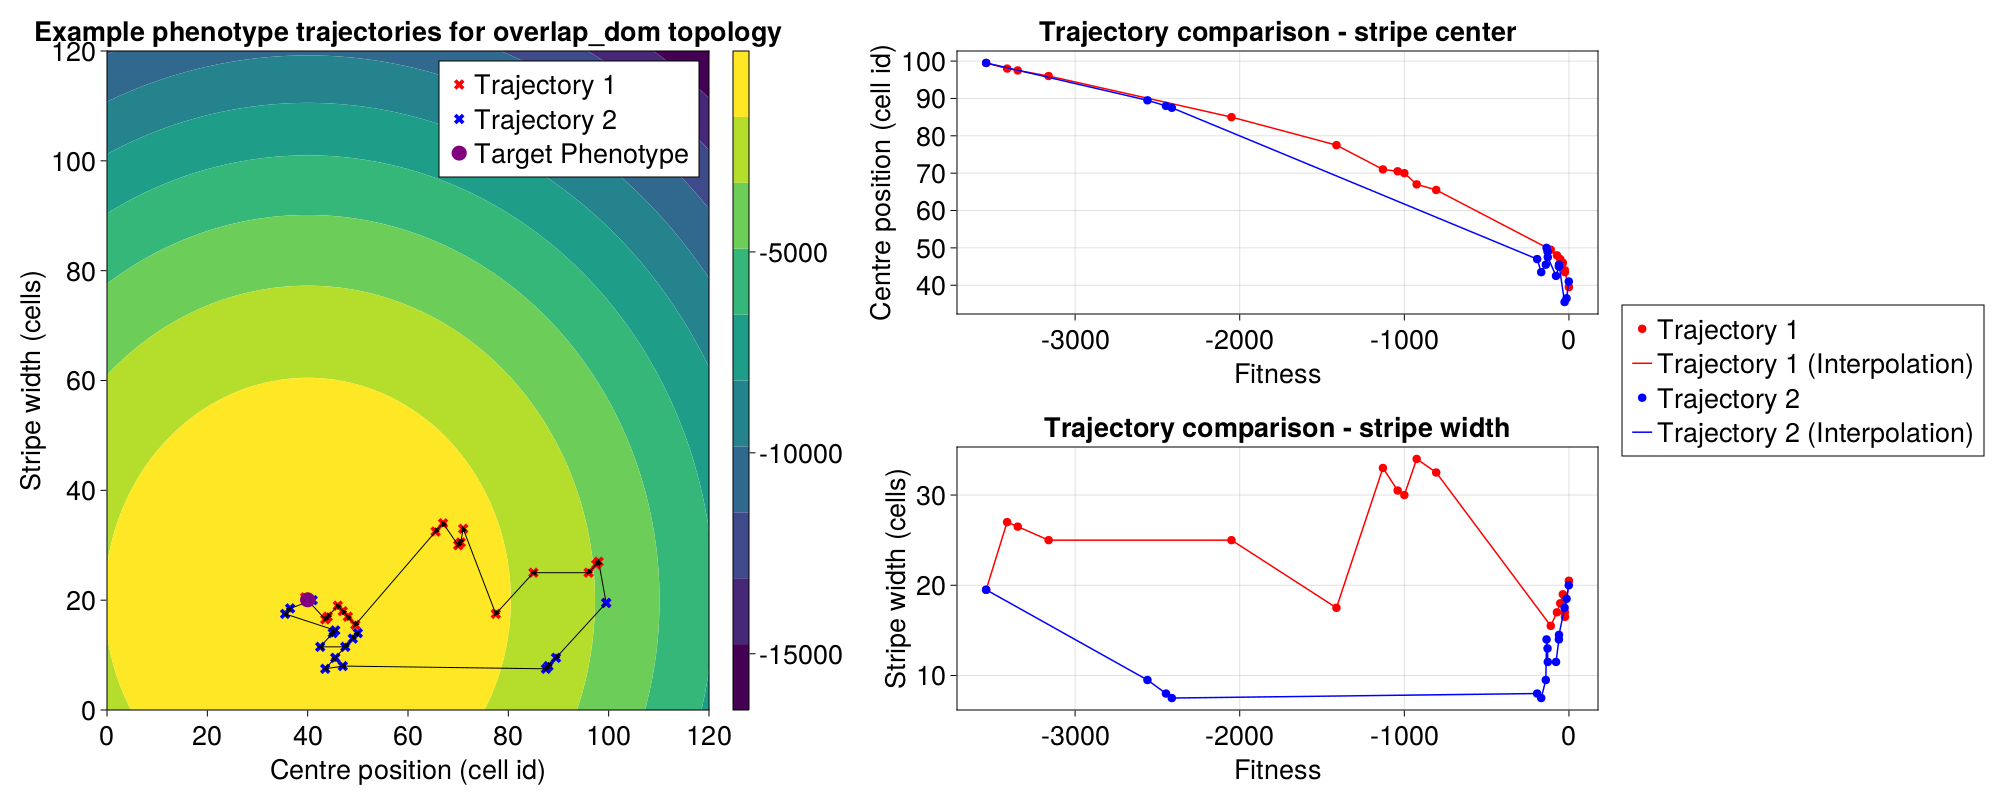

In [13]:
fig = plot_methodology_pheno_traj(pt, [12,8],topology, (40,20))

# CairoMakie.save(plotsdir("PhenoTrajectories",topology * "_methodology_example.png"),fig)

fig

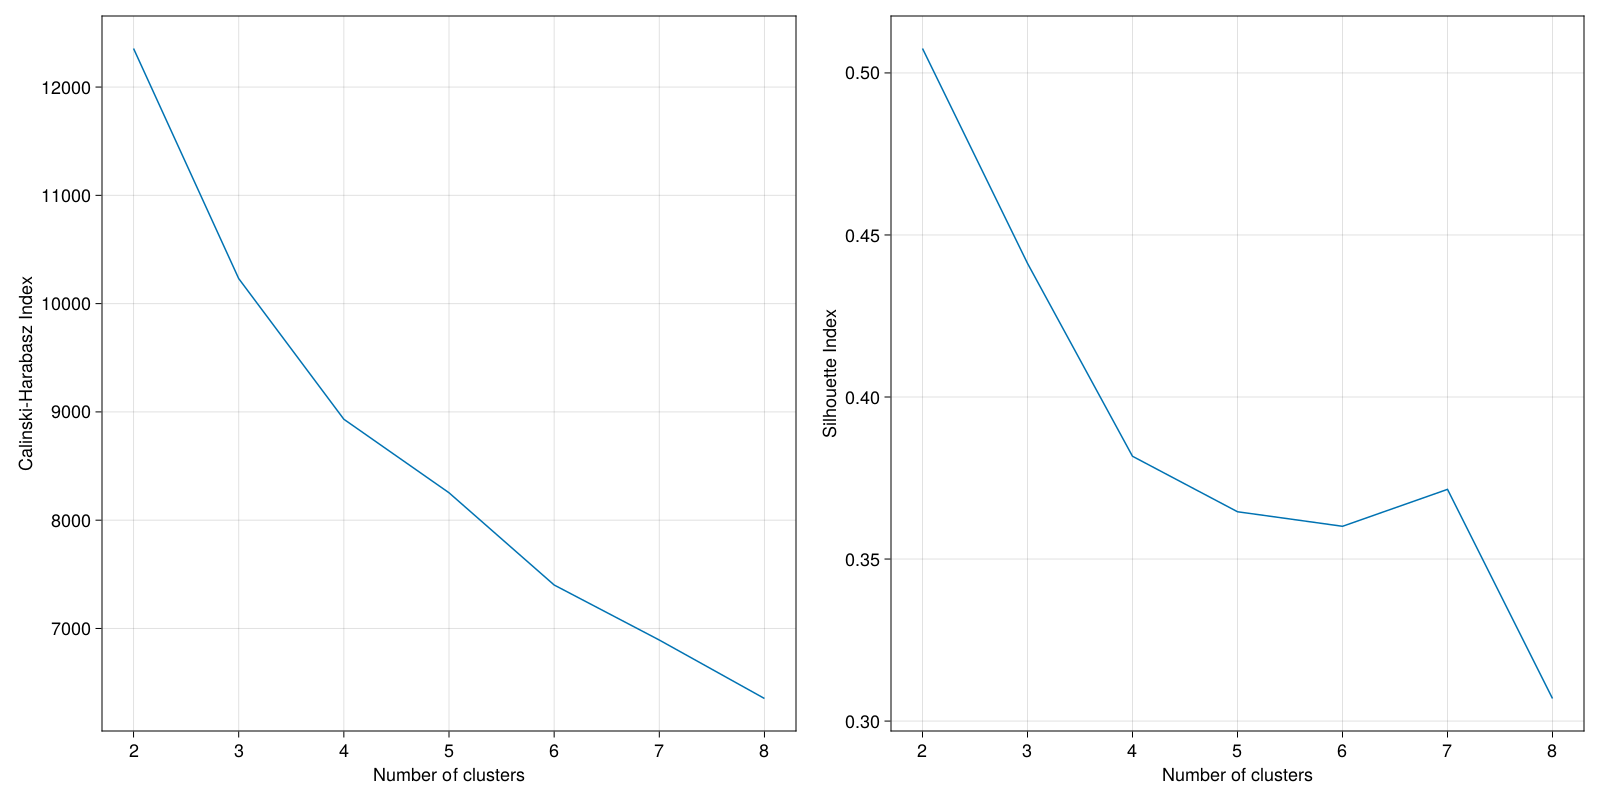

In [14]:
max_clusters = 8

determine_optimal_clusters_databased!(pt,max_clusters, CH(), SqEuclidean())

fig = CairoMakie.Figure(resolution = (1600, 800),fontsize = 18.)

ax = Axis(fig[1,1],xlabel = "Number of clusters", ylabel = "Calinski-Harabasz Index",xticks = (1:7,string.(2:8)))

CairoMakie.lines!(ax,pt.criterion_values)

determine_optimal_clusters_distancebased!(pt,max_clusters)

ax1 = Axis(fig[1,2],xlabel = "Number of clusters", ylabel = "Silhouette Index",xticks = (1:7,string.(2:8)))

CairoMakie.lines!(ax1,pt.criterion_values)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_clustered_pheno_CriterionIndex = " * string(pt.optimal_n_cluster) * ".png"),fig)
end
fig

┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260
┌ Warning: Unsupported marker: ●, using ● instead
└ @ Makie /Users/boothh/.julia/packages/Makie/iY5BJ/src/conversions.jl:1260


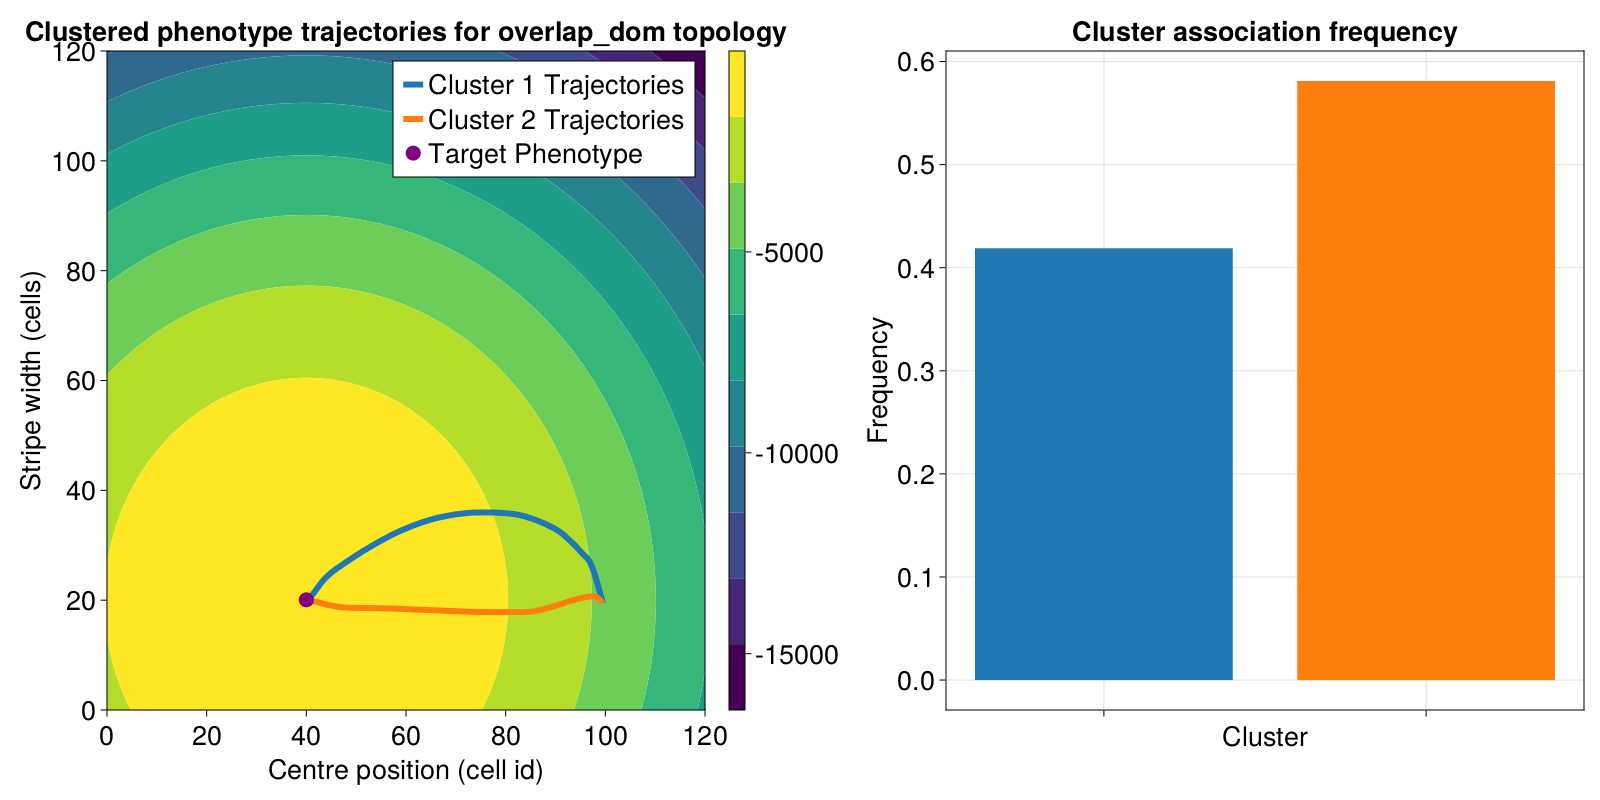

In [15]:
fig = plot_clustered_pheno_traj(pt,pt.optimal_n_cluster, topology, (40,20))

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_clustered_pheno_traj_n_cluster = " * string(pt.optimal_n_cluster) * ".png"),fig)
end
fig

In [16]:
function interpolate_geno_trajectories_by_fitness!(gt::GenoTrajectories,n)

    full_geno_traj = []

    for i in 1:length(gt.fitness_traj)
        full_weight_traj = zeros(size(gt.geno_traj[i],1),length(gt.initial_fitness:n:0))
        for wi in 1:size(gt.geno_traj[i],1)
            unique_geno_visits = unique(hcat(unique(gt.fitness_traj[i]),gt.geno_traj[i][wi,:]), dims = 1)
            fitness_timestamps = unique_geno_visits[:,1]
            itp_g = DataInterpolations.ConstantInterpolation(unique_geno_visits[:,2],fitness_timestamps);
            full_weight_traj[wi,:] = [itp_g(t) for t in gt.initial_fitness:n:0]
        end
        push!(full_geno_traj,full_weight_traj)
    end

    fgt_data = hcat(map(x->vec(x),full_geno_traj)...)

    gt.full_geno_traj = full_geno_traj;
    gt.fgt_data = fgt_data

end

function cluster_geno_trajectories_kmeans!(gt::GenoTrajectories,n_clusters::Int64,metric = SqEuclidean())

    R = kmeans(gt.fgt_data,n_clusters,distance = metric)

    gt.cluster_assignments = assignments(R);
end

function cluster_geno_trajectories_kmeans(gt::GenoTrajectories,n_clusters::Int64,metric = SqEuclidean())

    R = kmeans(gt.fgt_data,n_clusters,distance = metric)

    return assignments(R);
end


function determine_optimal_clusters_databased!(gt::GenoTrajectories,max_clusters::Int64,cluster_validity_index = CH(),cluster_metric = SqEuclidean())

    km_range = 2:max_clusters
    
    criterion_values = zeros(length(km_range))
    
    for (i, n_clust) = enumerate(km_range)
    
        assignments = cluster_geno_trajectories_kmeans(gt,n_clust,cluster_metric);
    
        cv = get_cvi!(cluster_validity_index, gt.fgt_data, assignments)

        if cv > maximum(criterion_values)
            gt.cluster_assignments = assignments
            gt.optimal_n_cluster = n_clust
        end

        criterion_values[i] = cv
    end

    gt.max_clusters = max_clusters
    gt.criterion_values = criterion_values
    
end

function determine_optimal_clusters_distancebased!(gt::GenoTrajectories,max_clusters::Int64,cluster_metric = SqEuclidean())

    km_range = 2:max_clusters
    
    criterion_values = zeros(length(km_range))

    gt.distance_mat = pairwise(SqEuclidean(),gt.fgt_data)
    
    for (i, n_clust) = enumerate(km_range)
    
        assignments = cluster_geno_trajectories_kmeans(gt,n_clust,cluster_metric);

        mi = mean(silhouettes(assignments, gt.distance_mat))

        if mi > maximum(criterion_values)
            gt.cluster_assignments = assignments
            gt.optimal_n_cluster = n_clust
        end

        criterion_values[i] = mi
    end

    gt.optimal_n_cluster = km_range[argmax(criterion_values)]
    gt.max_clusters = max_clusters
    gt.criterion_values = criterion_values
end

function cluster_geno_trajectories!(gt::GenoTrajectories,n_clusters::Int64,weight_n::Int64,metric = SqEuclidean())

    fgt_data = hcat(map(x->x[weight_n,:],gt.full_geno_traj)...)

    R = kmeans(fgt_data,n_clusters,distance = metric)

    gt.cluster_assignments = assignments(R);
end

function concat_matrices(v_m)

    r = zeros((size(v_m[1])...,length(v_m)))

    for i in 1:length(v_m)

        r[:,:,i] = v_m[i]

    end

    return r

end


concat_matrices (generic function with 1 method)

In [17]:
function select_marker(edge_value)
    edge_value > 0 ? :ltriangle : :vline
end

function draw_grn(network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.03, -0.05],
                [0.01, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    f, ax, p = graphplot(ng,layout = fixed_layout,node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]))

    p.elabels_rotation[] = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng))

    # offsets = 0.05 * (p[:node_pos][] .- p[:node_pos][][1])
    p.nlabels_offset[] = offsets

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)

    f,ax,p
end

function draw_grn!(ax,network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.075, -0.05],
                [0.025, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    graphplot!(ax,ng,layout = fixed_layout, node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]), elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)),nlabels_offset = offsets)

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end


draw_grn! (generic function with 1 method)

In [18]:
gt = GenoTrajectories(evo_traces);

interpolate_geno_trajectories_by_fitness!(gt,100);

In [ ]:
function plot_methodology_geno_traj(gt::GenoTrajectories, sample_choices::Vector{Int64}, topology_name::String,n)

    fig = CairoMakie.Figure(resolution = (1800, 1000),fontsize = 22.)

    color_scheme = palette(:tab10)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    # sample_choices = [12,2258]

    # Comparison chart

    gr = fig[1,2]

    full_fitness_traj = collect(gt.initial_fitness:n:0)

    for i in 1:length(sample_choices)

        ax  = Axis(gr[i,1], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Weight Value", title = "Evolutionary weight trajectory - example " * string(i))

        s_id = sample_choices[i]

        for wi in 1:10
            CairoMakie.lines!(ax,full_fitness_traj,gt.full_geno_traj[s_id][wi,:],color = color_scheme[wi],linewidth = 3.,label = "Weight " * weight_names[wi])
            CairoMakie.scatter!(ax,[t for t in zip(gt.fitness_traj[s_id],gt.geno_traj[s_id][wi,:])],color = color_scheme[wi])
        end

    end


    # leg = Legend(fig[1,1], ax)

    # ax3  = Axis(fig[1,3], backgroundcolor = "white")

    ax3  = Axis(fig[1,1], backgroundcolor = "white", title = topology_name * " - start network")

    draw_grn!(ax3,reshape(gt.initial_genotype,(3,4)),color_scheme)

    gr = fig[1,3]

    for i in 1:length(sample_choices)

        if i == 1
            ax  = Axis(gr[i,1], backgroundcolor = "white",title = "Evolved networks")
        else
            ax  = Axis(gr[i,1], backgroundcolor = "white")
        end

        s_id = sample_choices[i]

        draw_grn!(ax,reshape(gt.geno_traj[s_id][:,end],(3,4)),color_scheme)
    end

    return fig

end


In [19]:
fig = plot_methodology_geno_traj(gt, [12,2258], topology,100)

# CairoMakie.save(plotsdir("GenoTrajectories",topology * "_methodology_example.png"),fig)

UndefVarError: UndefVarError: plot_methodology_geno_traj not defined

In [20]:
# cluster_geno_trajectories!(gt,n_clusters,SqEuclidean());

In [21]:
function plot_clustered_geno_traj(gt::GenoTrajectories, n_clusters::Int64, topology_name::String,n)

    # cluster_geno_trajectories!(gt,n_clusters,SqEuclidean());
    
    res = 1000

    fig = CairoMakie.Figure(resolution = (res + 3.0*res/n_clusters, res),fontsize = 22.)

    color_scheme = palette(:tab10)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    gl = fig[1,2:4]

    grid_entries = Tuple.(findall(x-> x> 0,ones(Int64(ceil(sqrt(n_clusters))),Int64(ceil(sqrt(n_clusters))))))
    
    full_fitness_traj = collect(gt.initial_fitness:n:0)

    ax_list = []

    for cl in 1:n_clusters

        ass_cl = gt.full_geno_traj[findall(x->x==cl,gt.cluster_assignments)];

        all_m = concat_matrices(ass_cl)

        mt = mean(all_m,dims = 3)[:,:,1]
        std_t = std(all_m,dims = 3)[:,:,1]

        ax1  = Axis(gl[grid_entries[cl]...], backgroundcolor = "white", xlabel = "Fitness", ylabel = "Weight value", title = "Cluster " * string(cl))

        for i in 1:10
            CairoMakie.lines!(ax1,full_fitness_traj,mt[i,:], label = "Weight " * weight_names[i],color = color_scheme[i],linewidth = 5.)
            CairoMakie.band!(ax1,full_fitness_traj,mt[i,:] .- std_t[i,:],mt[i,:] .+ std_t[i,:],color = (color_scheme[i],0.5))
        end

        push!(ax_list,ax1)

    end

    gr = fig[1,1]

    leg = Legend(gr, ax_list[1])

    # Barplot

    gbp = fig[1,5]

    cd = cluster_density(gt, n_clusters)

    ocd_labels = sortperm(cd)

    ocd = cd[ocd_labels]

    ax2  = Axis(gbp[1,1], backgroundcolor = "white", xlabel = "Cluster", ylabel = "Frequency",xticks = (1:length(ocd_labels),string.(ocd_labels)),title = "Cluster association frequency")

    CairoMakie.barplot!(ax2,ocd)

    # GRN

    ax3  = Axis(gbp[2,1], backgroundcolor = "white",title = topology_name * " - start network")

    draw_grn!(ax3,reshape(gt.initial_genotype,(3,4)),color_scheme)

    return fig
end

plot_clustered_geno_traj (generic function with 1 method)

In [22]:
determine_optimal_clusters_databased!(gt,8, CH(), SqEuclidean());


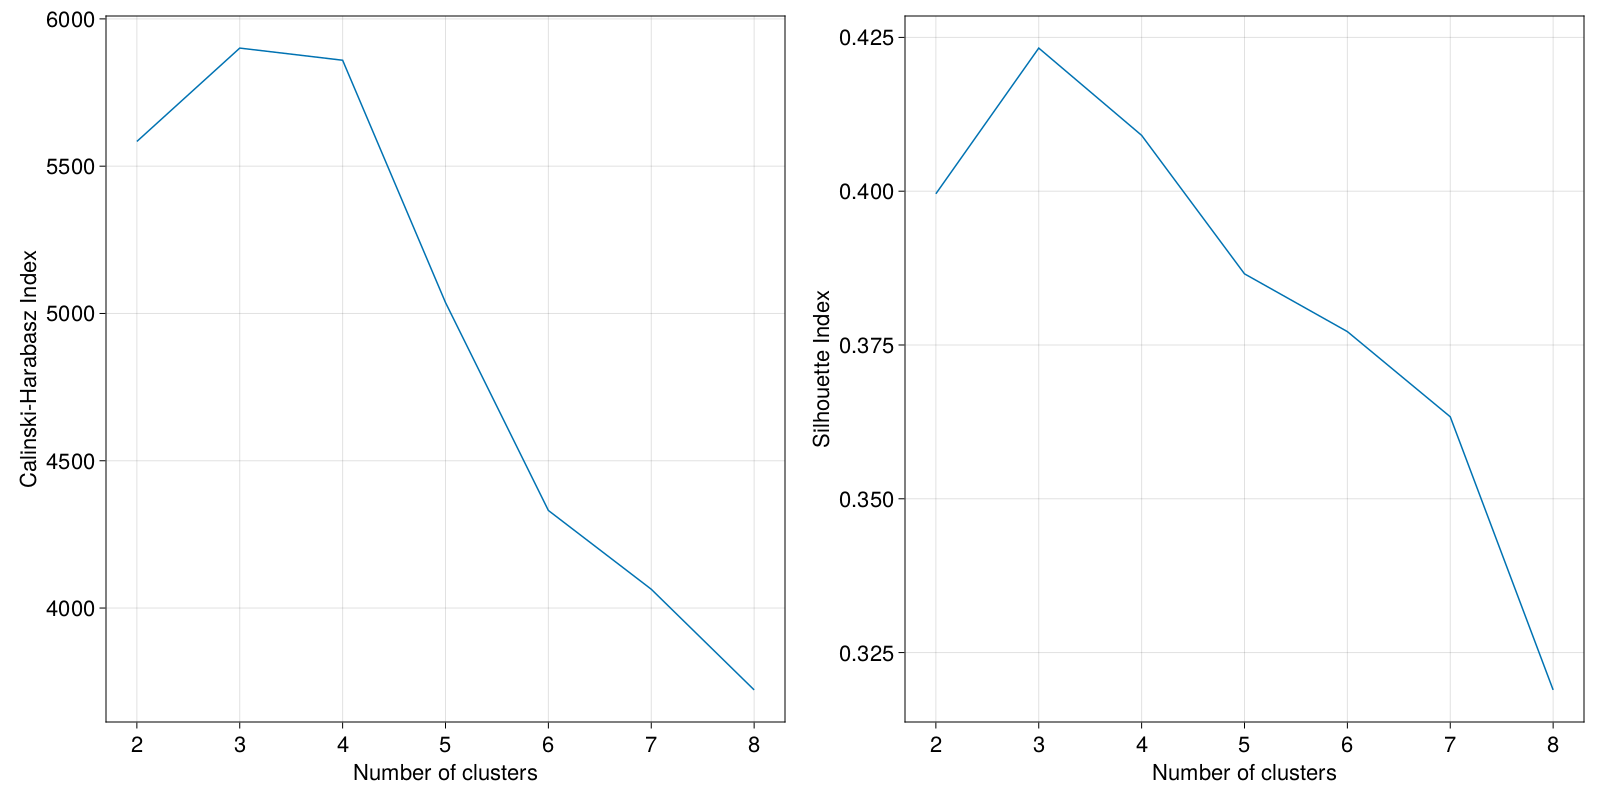

In [23]:
max_clusters = 8

fig = CairoMakie.Figure(resolution = (1600, 800),fontsize = 22.)

determine_optimal_clusters_databased!(gt,max_clusters, CH(), SqEuclidean())

ax = Axis(fig[1,1],xlabel = "Number of clusters", ylabel = "Calinski-Harabasz Index",xticks = (1:7,string.(2:8)))

CairoMakie.lines!(ax,gt.criterion_values)

determine_optimal_clusters_distancebased!(gt,max_clusters)

ax1 = Axis(fig[1,2],xlabel = "Number of clusters", ylabel = "Silhouette Index",xticks = (1:7,string.(2:8)))

CairoMakie.lines!(ax1,gt.criterion_values)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_clustered_geno_traj_IndexCriterion_ = " * string(gt.optimal_n_cluster) * ".png"),fig)
end
fig

In [24]:
determine_optimal_clusters_databased!(gt,max_clusters, CH(), SqEuclidean())

7-element Vector{Float64}:
 4896.2918949365485
 5117.371393146771
 5859.624070573047
 5037.0867400168845
 4611.232657613783
 3817.3224996583162
 3710.687100560499

In [25]:
gt.optimal_n_cluster

4

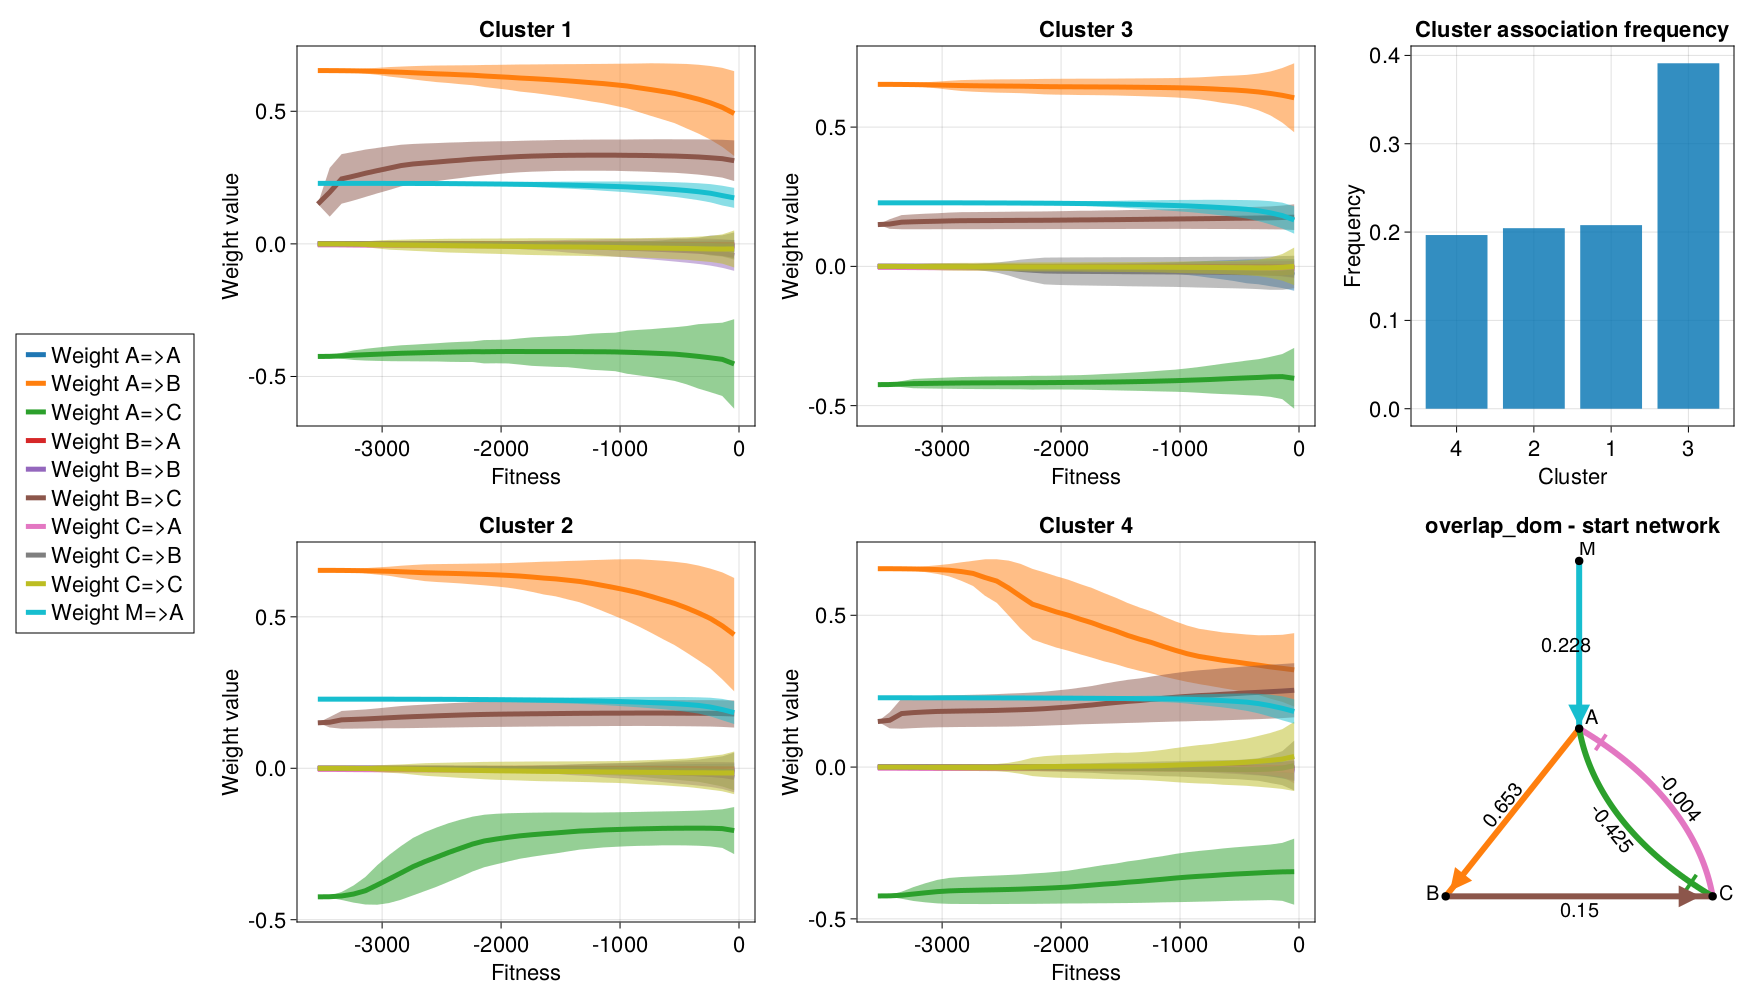

In [26]:
# save_t = true

fig = plot_clustered_geno_traj(gt, gt.optimal_n_cluster, topology,100)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_clustered_geno_traj_n_cluster = " * string(gt.optimal_n_cluster) * ".png"),fig)
end
fig

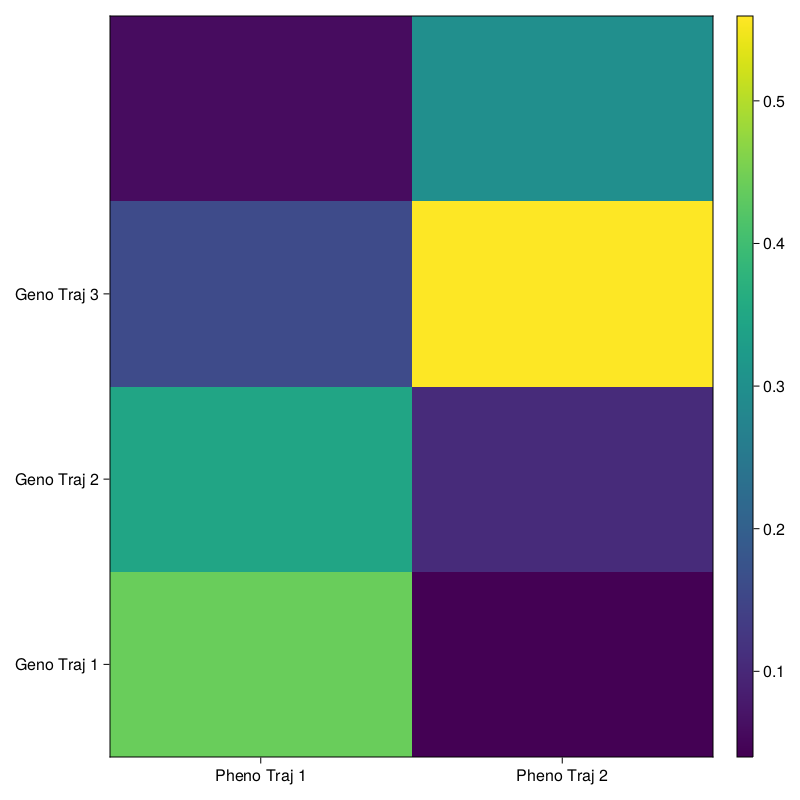

In [27]:
fig = CairoMakie.Figure(resolution = (800,800))
ax = Axis(fig[1,1],xticks = (1:2,["Pheno Traj 1", "Pheno Traj 2"]),yticks = (1:3,["Geno Traj 1", "Geno Traj 2","Geno Traj 3"]))

z = counts(pt.cluster_assignments,gt.cluster_assignments)

c = CairoMakie.heatmap!(ax,z ./ sum(z,dims = 2))

# CairoMakie.text!(ax,tuple.((1:3)'.-0.5, (1:2).-0.5), string.(z))

Colorbar(fig[1,2],c)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_clusterheatmap.png"),fig)
end

fig


In [41]:
gt.fgt_data

432×20000 Matrix{Float64}:
  0.0          0.0          0.0         …   0.0          0.0
  0.653415     0.653415     0.653415        0.653415     0.653415
 -0.424533    -0.424533    -0.424533       -0.424533    -0.424533
  0.0          0.0          0.0             0.0          0.0
  0.0          0.0          0.0             0.0          0.0
  0.150029     0.150029     0.150029    …   0.150029     0.150029
 -0.00379469  -0.00379469  -0.00379469     -0.00379469  -0.00379469
  0.0          0.0          0.0             0.0          0.0
  0.0          0.0          0.0             0.0          0.0
  0.228214     0.228214     0.228214        0.228214     0.228214
  ⋮                                     ⋱               
 -0.0350579   -0.056019     0.0             0.0          0.0
 -0.0238384    0.0         -0.139295        0.0          0.0
  0.278843     0.294778     0.370912    …   0.0999893    0.169179
 -0.0238736   -0.00379469  -0.00379469     -0.00379469  -0.00991257
  0.0          0.0     

In [66]:
lda = fit(MulticlassLDA, gt.fgt_data, pt.cluster_assignments; outdim=1)

MulticlassLDA{Float64}([0.0; 9.977808298099395e-12; … ; 0.0; 0.0;;], [-0.0876562583435852 -0.06538675541314756], MulticlassLDAStats{Float64, Matrix{Float64}, Matrix{Float64}}(432, 2, [8377.0, 11623.0], 20000.0, [0.0, 0.6534149419367132, -0.4245329552199313, 0.0, 0.0, 0.15002934476114654, -0.0037946873672185153, 0.0, 0.0, 0.2282136543544864  …  -0.36108440997351976, -0.0035345012005809653, -0.021789516035153333, 0.22068457406371494, -0.010886372834656509, -0.01079947443737779, -0.00012652153375542779, 0.17470650201974977, 0.0, 0.0], [0.0 0.0; 0.6534149419367125 0.6534149419367137; … ; 0.0 0.0; 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 2.3300903664075142e-23 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 7.35170292454571e-27 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]))

In [70]:
Ylda = predict(lda,gt.fgt_data)

1×20000 Matrix{Float64}:
 -0.102074  -0.0973648  -0.0849333  …  -0.0533498  -0.0973431  -0.0704663

In [98]:
dot(projection(lda),gt.fgt_data[:,3])

-0.08493325465704357

In [ ]:
imp_mat = reshape(projection(lda),size(gt.full_geno_traj[1]))

In [100]:
R = 0.
for i in 1:12
    R += dot(imp_mat[i,:],gt.full_geno_traj[1][i,:])
end

R

-0.10207350154067468

In [101]:
R = zeros(12,20000)

for j in 1:20000
    for i in 1:12
        R[i,j] = dot(imp_mat[i,:],gt.full_geno_traj[j][i,:])
    end
end



In [104]:
sum(R,dims = 1)

1×20000 Matrix{Float64}:
 -0.102074  -0.0973648  -0.0849333  …  -0.0533498  -0.0973431  -0.0704663

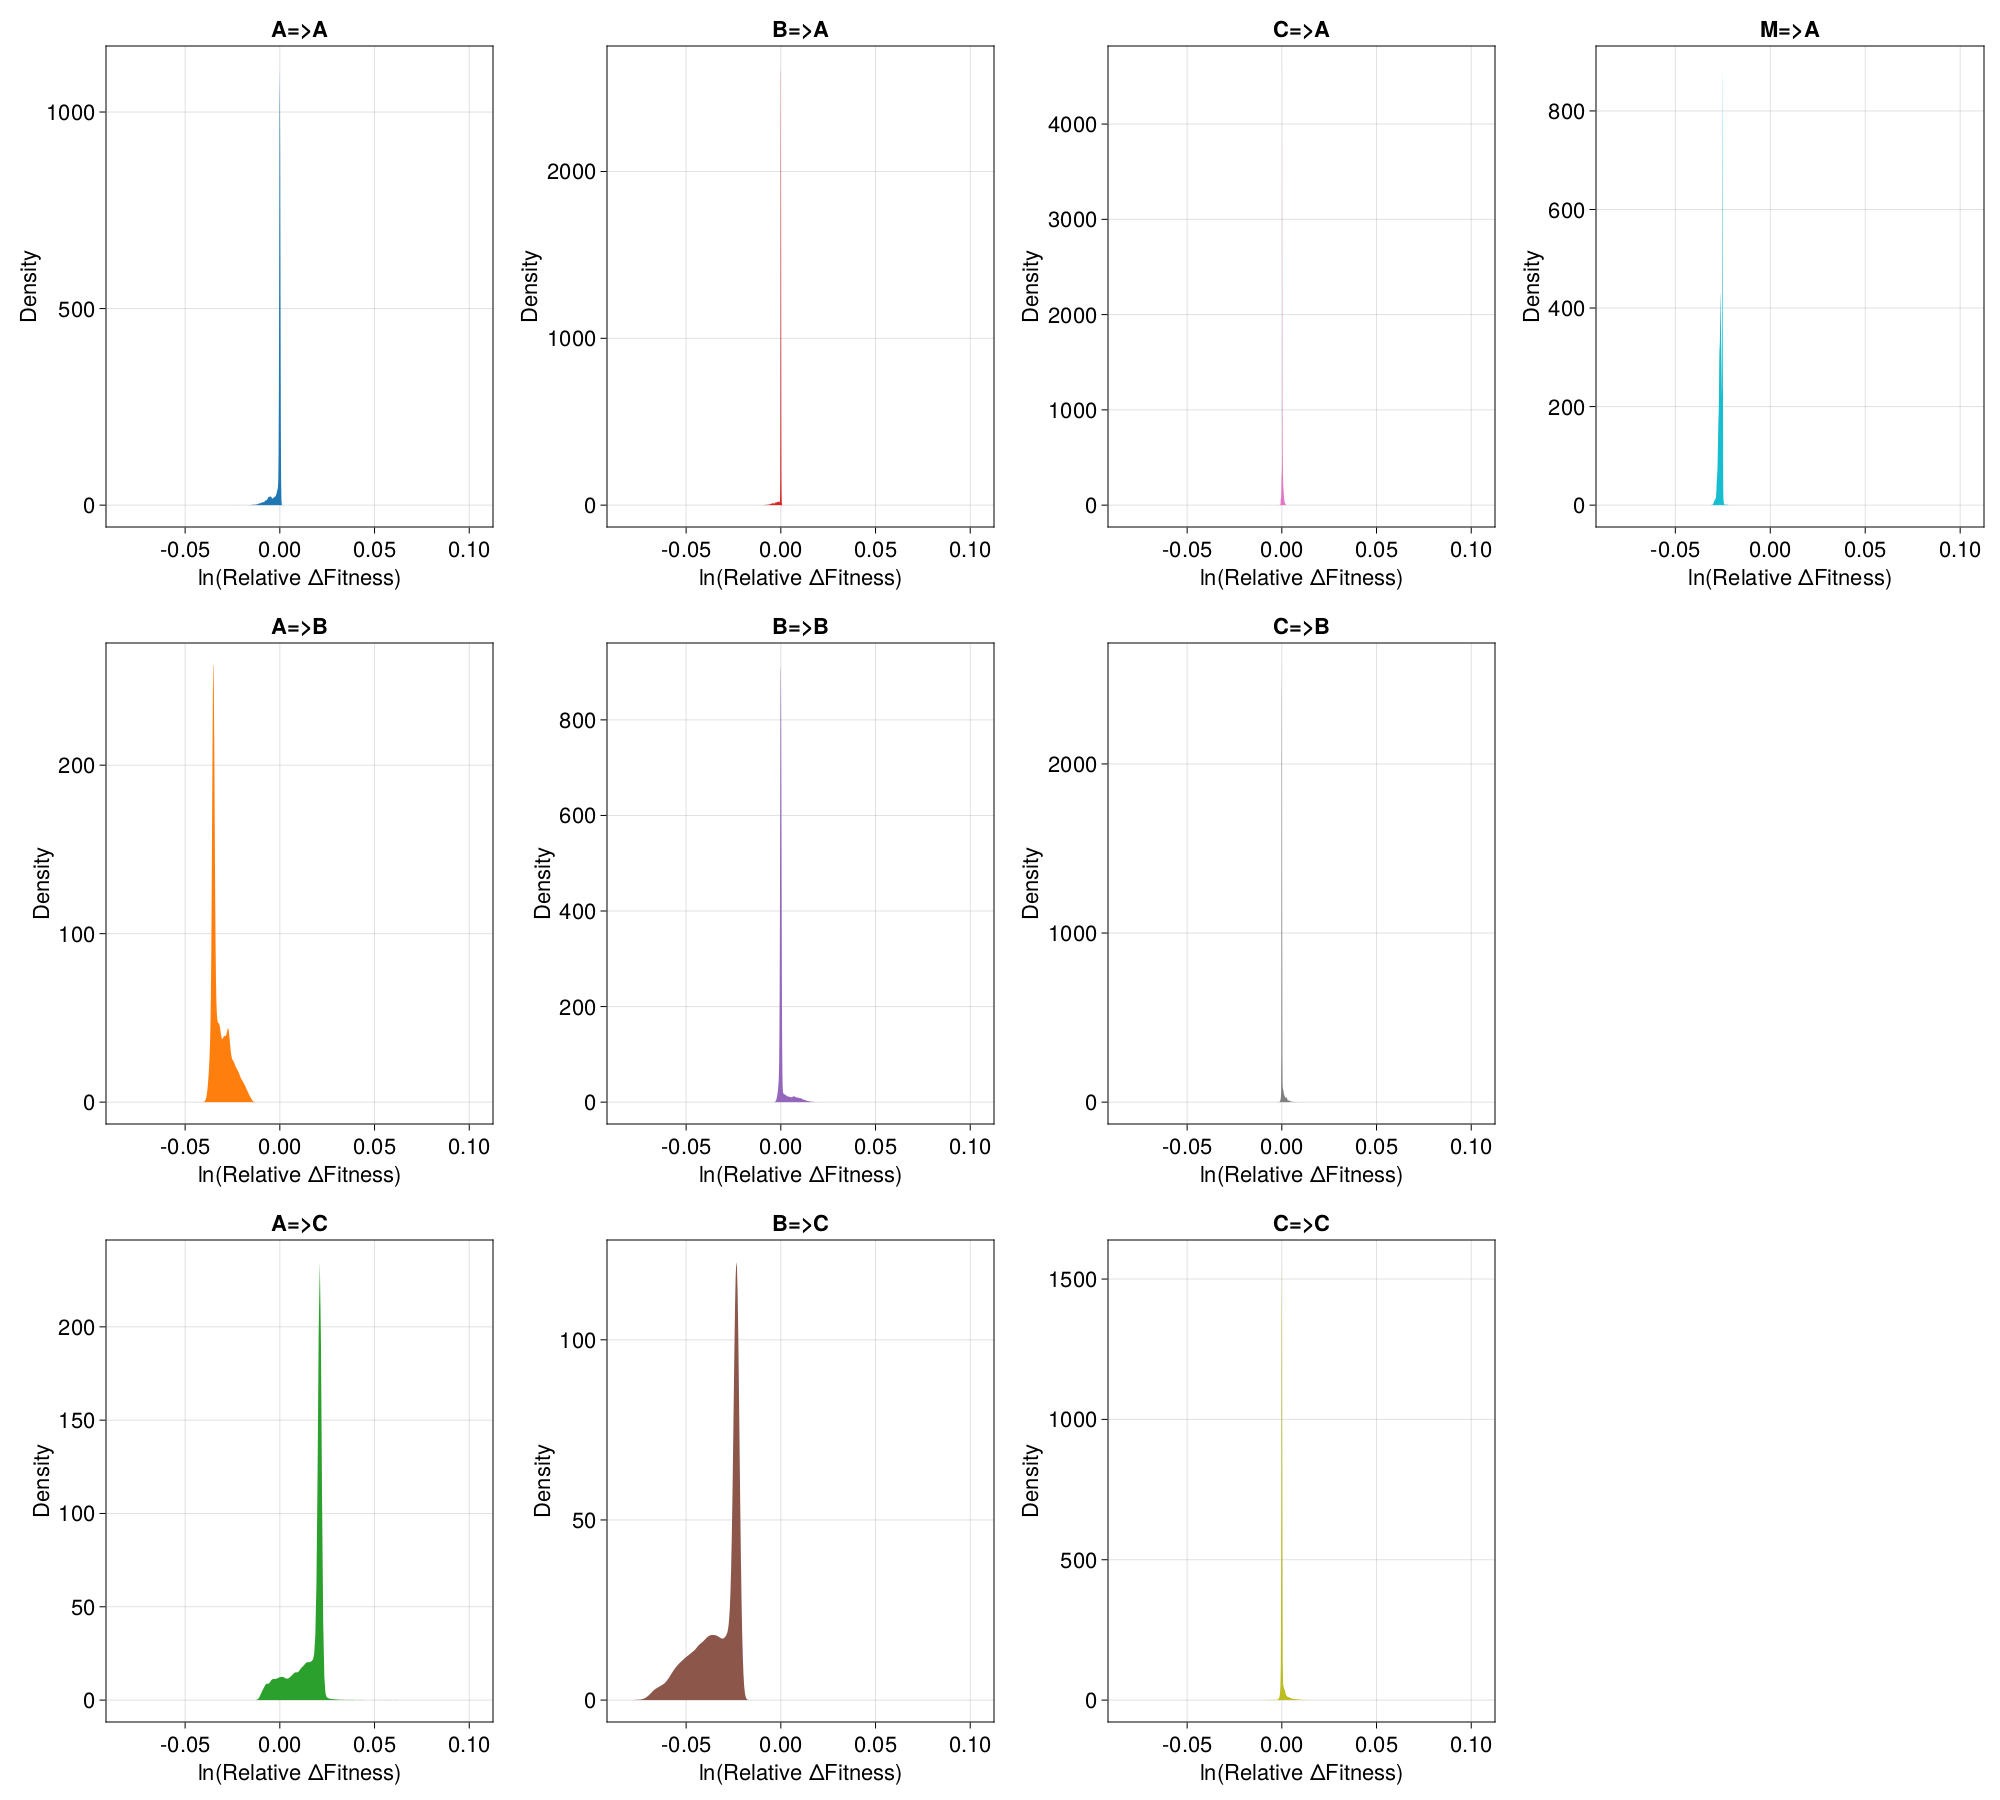

In [118]:


fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="ln(Relative ΔFitness)", ylabel="Density", title = weight_names[wi]) 

    # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

    CairoMakie.density!(ax1,R[wi,:],color = color_scheme[wi],nbins = 100)

    push!(ax_list,ax1)

end

linkxaxes!(ax_list...)

fig

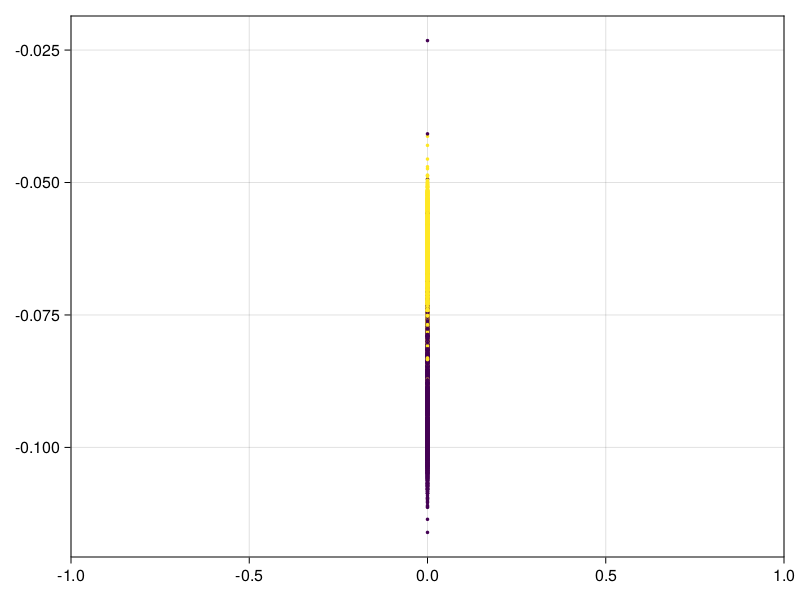

In [77]:
CairoMakie.scatter(hcat(zeros(length(Ylda)),Ylda |> transpose |> collect),color = pt.cluster_assignments,markersize = 5.)

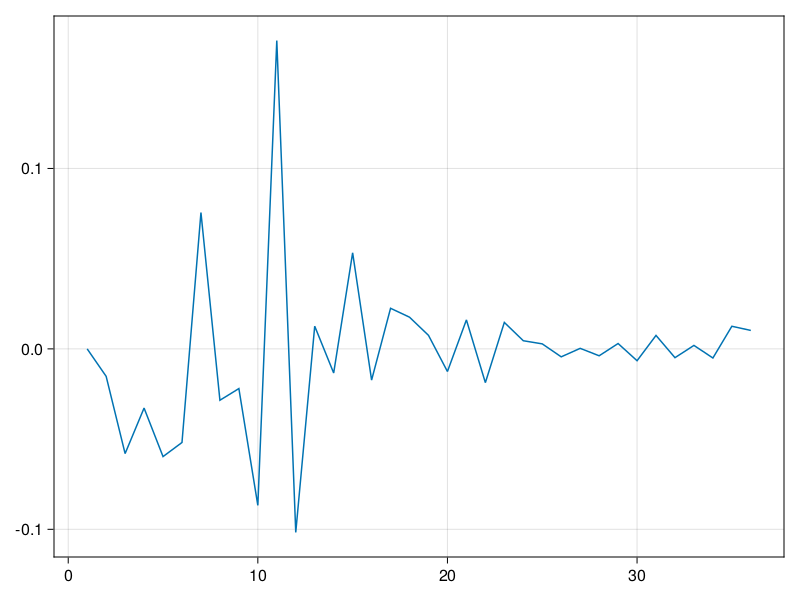

In [93]:
CairoMakie.lines(imp_mat[10,:])

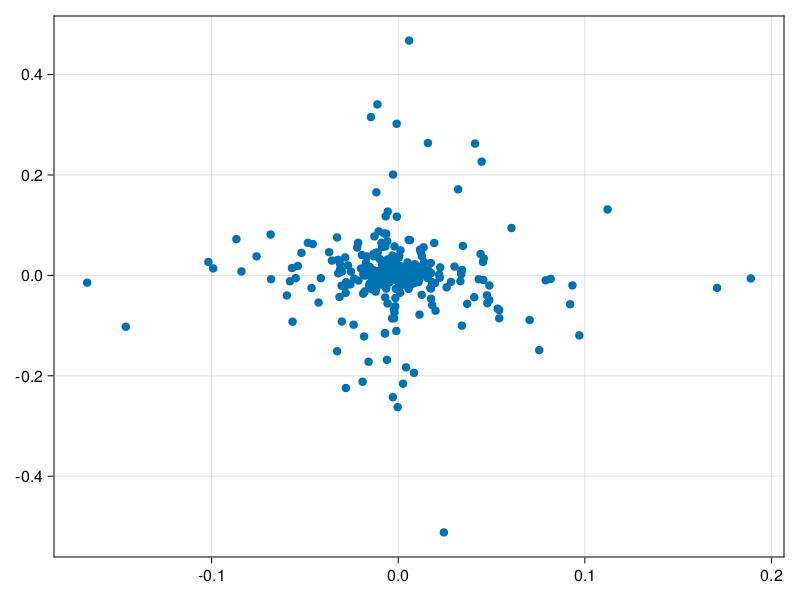

In [51]:
CairoMakie.scatter(projection(lda))

In [65]:
projection(lda)

432×2 Matrix{Float64}:
  0.0           0.0
  9.97781e-12  -3.39637e-14
  5.61025e-10  -1.26434e-12
  0.0           0.0
  0.0           0.0
  1.2699e-11   -4.84078e-13
  4.99599e-13   3.23621e-14
  0.0           0.0
  0.0           0.0
 -2.67587e-11   1.411e-12
  ⋮            
 -0.00638437    0.000594242
  0.0157336     0.00212748
  0.00303554   -0.0113346
  0.00514127    0.00120165
  0.00224904    0.00209351
  0.00376901   -0.000360872
  0.0102176     0.000597822
  0.0           0.0
  0.0           0.0

In [64]:
gt.full_geno_traj[1]

12×36 Matrix{Float64}:
  0.0          0.0          0.0         …   0.0         0.0         0.0
  0.653415     0.653415     0.653415        0.653415    0.653415    0.653415
 -0.424533    -0.424533    -0.424533       -0.386435   -0.386435   -0.386435
  0.0          0.0          0.0            -0.0350579  -0.0350579  -0.0350579
  0.0          0.0          0.0             0.0         0.0        -0.0238384
  0.150029     0.150029     0.150029    …   0.278843    0.278843    0.278843
 -0.00379469  -0.00379469  -0.00379469     -0.0238736  -0.0238736  -0.0238736
  0.0          0.0          0.0             0.0         0.0         0.0
  0.0          0.0          0.0            -0.0464315  -0.124751   -0.124751
  0.228214     0.228214     0.228214        0.228214    0.228214    0.228214
  0.0          0.0          0.0         …   0.0         0.0         0.0
  0.0          0.0          0.0             0.0         0.0         0.0

In [54]:
cca = fit(CCA, gt.fgt_data, pt.fpt_data ; outdim = 2)

CCA (xindim = 432, yindim = 710, outdim = 2)

In [62]:
projection(cca,:x)

432×2 Matrix{Float64}:
   6.23751e16  -1.2806e14
  -3.60796e16   7.79963e13
   1.31303e16  -3.48495e13
   1.02855e15  -2.60954e13
   8.79718e14  -3.62023e13
  -1.51106e16   5.71603e13
   1.05977e16  -3.22744e13
   2.24982e16  -4.53435e13
  -1.47983e16   1.95095e14
   1.75385e16  -5.48853e13
   ⋮           
  42.855       -0.171484
 -11.7287      -0.192046
 -32.7726       0.0127107
  38.3543      -0.121547
  14.8642      -0.03717
  -2.46491     -0.0811788
 -58.4571       0.216744
  -1.92477      4.48874e13
  -0.878092    -5.73802e12

In [30]:
z ./ sum(z,dims = 2)

2×4 Matrix{Float64}:
 0.44085    0.346067  0.157455  0.0556285
 0.0399208  0.102297  0.559494  0.298288

In [31]:
function count_set(df, cols, setcols)
    count(eachrow(df)) do row
        any(ismissing, row[cols[setcols]])        && return false # all setcols must be non-missing
        !all(row[cols[setcols]])                  && return false # all set colls must be true
        any(skipmissing(row[cols[Not(setcols)]])) && return false # no non-set cols can be true
        return true
    end
end

function upset_dots!(ax, colsets, nsets=maximum(Iterators.flatten(colsets)))
    CairoMakie.xlims!(ax, (0, length(colsets) + 1))
    CairoMakie.hidedecorations!(ax)
    CairoMakie.hidespines!(ax)

    for (x, p) in enumerate(colsets)
        CairoMakie.scatter!(ax, fill(x, nsets - length(p)), collect(1:nsets)[Not(p)], markersize=16, color=:lightgray)
        CairoMakie.scatter!(ax, fill(x, length(p)), p, markersize=16, color=:black)
        length(p) > 1 && lines!(ax, [x,x], [extrema(p)...], color=:black, linewidth=3)
    end
end

function plot_pt_gt_alignment(pt::PhenoTrajectories,gt::GenoTrajectories)
    cl_assign = []
    ycols = []

    for i in 1:pt.optimal_n_cluster
        push!(cl_assign,pt.cluster_assignments .== i)
        push!(ycols,"Pheno_cl_" * string(i))
    end

    for i in 1:gt.optimal_n_cluster
        push!(cl_assign,gt.cluster_assignments .== i)
        push!(ycols,"Geno_cl_" * string(i))
    end

    data = reduce(hcat,cl_assign);

    df = DataFrame(data,ycols);

    result = ones(8,8)

    for i in 1:size(data,2)
        for j in 1:size(data,2)
            if i != j
                result[i,j] = maximum(data[:,i] .+ data[:,j])
            end
        end
    end

    fig = CairoMakie.Figure(resolution = (1000,1000))
    intersection_ax = Axis(fig[1,1], ylabel="intersection size", yautolimitmargin = (0, 0.15))
    dot_ax = Axis(fig[2,1])
    set_ax = Axis(fig[2,2], xlabel="set size", yticks = (1:size(data,2), string.(ycols)),
        xautolimitmargin = (0, 0.15), yticklabelpad = 10, xgridvisible = false)

    intersects = map(x->[x...],unique(Set.(Tuple.(findall(x-> x.> 1,result)))))

    color_scheme = palette(:tab10)

    bar_colors = [palette(:grays)[1] for i in 1:size(data,2)]

    for i in 1:pt.optimal_n_cluster
        bar_colors[i] = color_scheme[i]
    end

    barplot!(intersection_ax, 1:length(intersects),
                            [count_set(df, ycols, i) for i in intersects],
            bar_labels=:y, color = :gray20,
            label_size = 14, label_formatter = x -> string(Int(x)))

    barplot!(set_ax, 1:size(data,2), [count(df[!, col]) for col in ycols], 
                    direction=:x, bar_labels=:y, label_size = 14, color = bar_colors,
                    label_formatter = x -> string(Int(x)))

    for i in 1:2:length(ycols)
    poly!(dot_ax,
        BBox(0, length(intersects) + 1, i-0.5, i+0.5),
        color = :gray95
    )
    end

    upset_dots!(dot_ax, intersects)
    hidexdecorations!(intersection_ax)
    hideydecorations!(set_ax, ticklabels = false)

    rowgap!(fig.layout, 0)
    linkyaxes!(dot_ax, set_ax)
    linkxaxes!(dot_ax, intersection_ax)
    hidespines!(intersection_ax, :t, :r, :b)
    hidespines!(set_ax, :t, :r, :l)

    return fig
end

plot_pt_gt_alignment (generic function with 1 method)

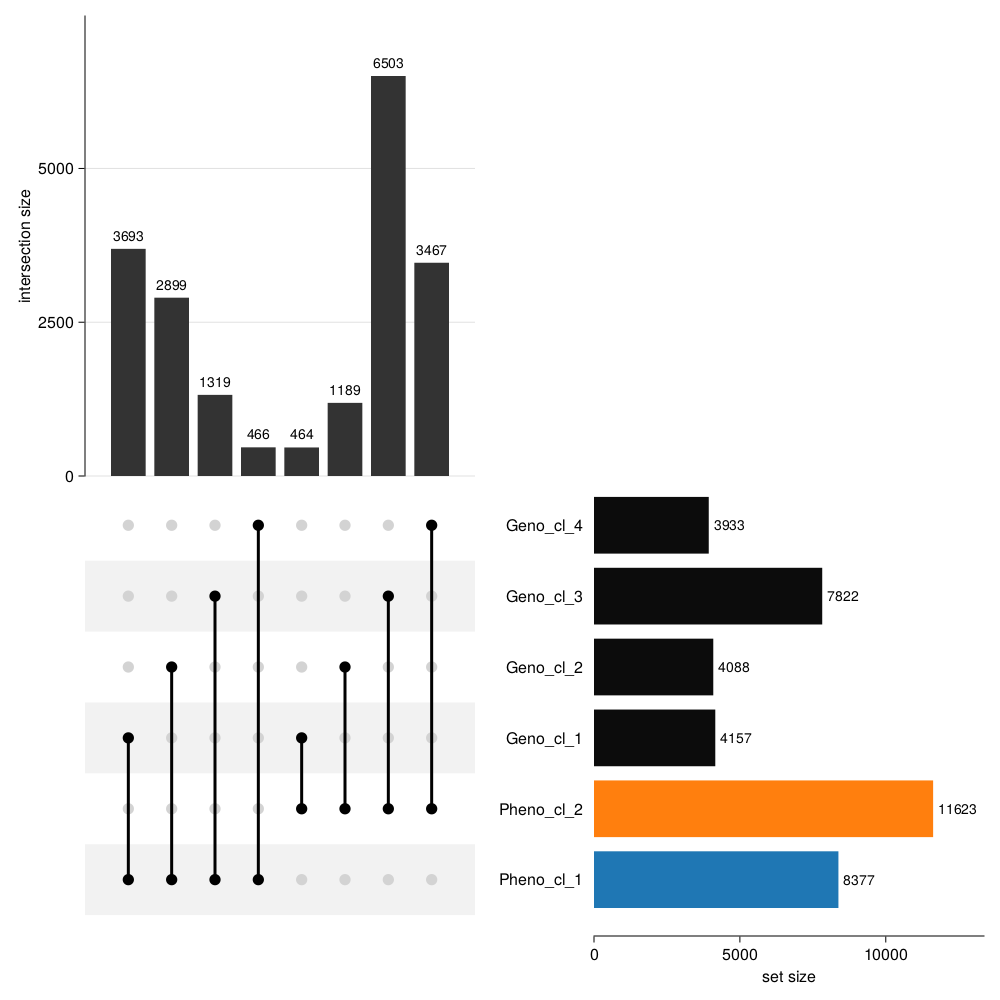

In [32]:
fig = plot_pt_gt_alignment(pt,gt)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_cluster_comparison_gt_cl = " * string(gt.optimal_n_cluster) * "_pt_cl = " * string(pt.optimal_n_cluster) * ".png"),fig)
end
fig

In [33]:
ass_cl = gt.full_geno_traj[findall(x->x==1,gt.cluster_assignments)];

all_m = concat_matrices(ass_cl)

mt = mean(all_m,dims = 3)[:,:,1]
std_t = std(all_m,dims = 3)[:,:,1]

12×36 Matrix{Float64}:
 0.0          3.65543e-5   0.000102351  …  0.0194046   0.0211505  0.0233296
 2.90913e-14  0.00106352   0.00335085      0.138898    0.149062   0.159819
 2.38171e-14  0.0036552    0.0109489       0.129698    0.138141   0.168816
 0.0          5.95101e-6   2.68147e-5      0.0101461   0.0109308  0.0115884
 0.0          6.89951e-5   0.000180852     0.0506391   0.054088   0.0579808
 1.29634e-14  0.0919355    0.09348      …  0.0685951   0.0713468  0.0766721
 3.8689e-16   0.000142392  0.000700241     0.00782115  0.0106692  0.0137829
 0.0          0.000181144  0.000553633     0.0376404   0.0399515  0.0513241
 0.0          0.0          0.00302296      0.0489349   0.0552737  0.0698514
 1.20474e-14  7.23135e-5   0.000169856     0.0344028   0.037268   0.0377281
 0.0          0.0          0.0          …  0.0         0.0        0.0
 0.0          0.0          0.0             0.0         0.0        0.0

In [34]:
function get_first_mutation(traj)
    findall(x->x!=0,traj[:,2] .- traj[:,1])[1]
end

get_first_mutation (generic function with 1 method)

In [35]:
first_mutations = map(x->get_first_mutation(x),gt.geno_traj);

In [36]:
counts(first_mutations,gt.cluster_assignments)

10×4 Matrix{Int64}:
   23    34   604    32
  206   184   349  1412
  202  1929   358   397
    1    16   326     8
   72    69   209    26
 2435   597  1115  1130
 1082  1040  1795   720
   37    51   806    57
    0     0     0     0
   99   168  2260   151

In [37]:
counts(first_mutations,pt.cluster_assignments)

10×2 Matrix{Int64}:
  155   538
  362  1789
 1760  1126
    8   343
   46   330
 3674  1603
 2100  2537
   66   885
    0     0
  206  2472

In [38]:
countmap(first_mutations) 

Dict{Int64, Int64} with 9 entries:
  5  => 376
  4  => 351
  6  => 5277
  7  => 4637
  2  => 2151
  10 => 2678
  8  => 951
  3  => 2886
  1  => 693

In [39]:
function sample_via_fm(first_mutations,min_n)
    all_samples = []
    for fm in unique(first_mutations)
        weights = Weights(Float64.(first_mutations .== fm))
        push!(all_samples,sample(collect(1:length(first_mutations)),weights,min_n,replace = false))
    end
    return reduce(vcat,all_samples)
end

sample_via_fm (generic function with 1 method)

In [40]:
choices = sample_via_fm(first_mutations,351);

choice_full = [[n in choices for _ in 1:length(t)] for (n,t) in enumerate(gt.traj)]

choice_full_v = findall(x->x,reduce(vcat,choice_full ));

first_network = [[i == 1 for i in 1:length(t)] for (n,t) in enumerate(gt.traj)]

first_network_v = reduce(vcat,first_network );

first_network_id = findall(x->x ,first_network_v);

end_network = [[i == length(t) for i in 1:length(t)] for (n,t) in enumerate(gt.traj)]

end_network_v = reduce(vcat,end_network );

end_network_id = findall(x->x ,end_network_v);

In [ ]:
full_phenotypes = load(datadir("precompute_pheno.jld"))["full_pheno"];

In [ ]:
full_phenotypes_vec = map(vm->reduce(hcat,map(m->vec(m),vm)),full_phenotypes)
g12_phenotypes_vec = map(vm->reduce(hcat,map(m->vec(m[1:2,:]),vm)),full_phenotypes)
g3_phenotypes_vec = map(vm->reduce(hcat,map(m->vec(m[3,:]),vm)),full_phenotypes);

In [ ]:
pheno_X = reduce(hcat,full_phenotypes_vec)
pheno_g3_X = reduce(hcat,g3_phenotypes_vec)
pheno_g12_X = reduce(hcat,g12_phenotypes_vec)

In [ ]:
fitness_X = reduce(vcat,map(x->unique(x),pt.fitness_traj));
cw_X = reduce(vcat,pt.pheno_traj);


In [ ]:
function centre_line(w,w_min,w_max,w_target,scalar = 0.5)
    if w > w_target
        if w < w_max
            return 0.5 + scalar*(w-w_target)/(w_max - w_target)
        else
            return 1.
        end
    else
        if w > w_min
            return 0.5 - scalar*(w_target-w)/(w_target - w_min)
        else
            return 0.
        end
    end
end

uniqueidx(v) = unique(i -> v[:,i], 1:size(v,2))

target = (40,20)

pheno_width = map(x->last(x),cw_X)
pheno_centre = map(x->first(x),cw_X)

pw_min = minimum(pheno_width)
pw_max = maximum(pheno_width)

pc_min = minimum(pheno_centre)
pc_max = maximum(pheno_centre)

pheno_width_colour = map(x->centre_line(x,pw_min,pw_max,target[2]),pheno_width);
pheno_centre_colour = map(x->centre_line(x,pc_min,pc_max,target[1]),pheno_centre);

In [ ]:
fitness_colour =  fitness_X

In [ ]:
traj_geno_class = [[gt.cluster_assignments[n] for _ in 1:length(t)] for (n,t) in enumerate(gt.traj)]

traj_geno_class_v = reduce(vcat,traj_geno_class )

traj_pheno_class = [[pt.cluster_assignments[n] for _ in 1:length(t)] for (n,t) in enumerate(pt.pheno_traj)]

traj_pheno_class_v = reduce(vcat,traj_pheno_class );

first_mutation_class = [[first_mutations[n] for _ in 1:length(t)] for (n,t) in enumerate(gt.traj)]

traj_fm_class_v = reduce(vcat,first_mutation_class);

In [ ]:
phate_op = phate.PHATE(knn = 150, gamma = 0.,n_jobs = -2,random_state = 999)

In [ ]:
phate_pheno_g3 = phate_op.fit_transform(pheno_g3_X[:,choice_full_v] |> transpose |> collect);

In [ ]:
max_height_g3 = maximum(pheno_g3_X[:,choice_full_v], dims = 1);

In [ ]:
target_point_1 = [-0.02,0.]

distances_tp1 = mapslices(x->norm(x .- target_point_1), phate_pheno_g3,dims = 2)[:,1]

closest_tp1 = sortperm(distances_tp1);


In [ ]:
id_sample_start = map(x->x ∈ first_network_id,choice_full_v);

In [ ]:
id_sample_end = map(x->x ∈ end_network_id,choice_full_v);

In [ ]:
start_pos_phate_3 = phate_pheno_g3[id_sample_start,:][1,:]

In [ ]:
path_data = pheno_g3_X[:,choice_full_v];

t_features = fit(ZScoreTransform, path_data ; dims = 2)

scaled_path_data = map(x->isnan(x) ? 0. : x, StatsBase.transform(t_features,path_data));

M = fit(PCA, scaled_path_data; pratio=1, maxoutdim=2);

In [ ]:
path_data_transform = MultivariateStats.transform(M, scaled_path_data)

start_pos_pca_3 = path_data_transform[:,id_sample_start][:,1];

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories (colour representing fitness)")

c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5., color = fitness_colour[choice_full_v])

CairoMakie.scatter!(ax,start_pos_phate_3 |> transpose |> collect,markersize = 20., color = :pink)

CairoMakie.scatter!(ax,phate_pheno_g3[closest_tp1[end],:] |> transpose |> collect,markersize = 20., color = :red)

CairoMakie.scatter!(ax,phate_pheno_g3[closest_tp1[1],:] |> transpose |> collect,markersize = 20., color = :blue)

CairoMakie.scatter!(ax,phate_pheno_g3[closest_tp1[3],:] |> transpose |> collect,markersize = 20., color = :orange)

ax1 = Axis(fig[1,2], xlabel = "PCA 1", ylabel = "PCA 2", title = "PCA EMBEDDING of Gene C, " * string(length(choices)) * " trajectories. Explained variance = " * string(principalratio(M)))

CairoMakie.scatter!(ax1,path_data_transform ,markersize = 5., color =  fitness_colour[choice_full_v])

CairoMakie.scatter!(ax1,start_pos_pca_3 |> transpose |> collect,markersize = 20., color = :pink)

CairoMakie.scatter!(ax1,path_data_transform[:,closest_tp1[end]][:,1] |> transpose |> collect,markersize = 20., color = :red)

CairoMakie.scatter!(ax1,path_data_transform[:,closest_tp1[1]][:,1] |> transpose |> collect,markersize = 20., color = :blue)

CairoMakie.scatter!(ax1,path_data_transform[:,closest_tp1[3]][:,1] |> transpose |> collect,markersize = 20., color = :orange)

Colorbar(fig[1,3], c)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_Fitness.png"),fig)
end 

fig

In [ ]:
pheno_tp1_1 = pheno_g3_X[:,choice_full_v][:,closest_tp1[1]]

pheno_tp1_2 = pheno_g3_X[:,choice_full_v][:,closest_tp1[3]]

pheno_tp1_3 = pheno_g3_X[:,choice_full_v][:,closest_tp1[end]];

fig = CairoMakie.Figure(resolution = (1000,300),fontsize = 22.)

ax = Axis(fig[1,1])

CairoMakie.lines!(ax,pheno_tp1_1, color = :blue)
CairoMakie.lines!(ax,pheno_tp1_2, color = :orange)
CairoMakie.lines!(ax,pheno_tp1_3, color = :red)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_PointExamples.png"),fig)
end
fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories (colour representing stripe width)")

c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5.,color = pheno_width[choice_full_v],colormap=cgrad([:red,:yellow,:blue]))

CairoMakie.scatter!(ax,start_pos_phate_3 |> transpose |> collect,markersize = 20., color = :pink)

Colorbar(fig[1,2], c)

# ax1 = Axis(fig[1,2], xlabel = "PCA 1", ylabel = "PCA 2", title = "PCA EMBEDDING of " * string(length(choices)) * " trajectories. Explained variance = ")

# CairoMakie.scatter!(ax1,path_data_transform ,markersize = 5., color = pheno_width[choice_full_v],colormap=cgrad([:red,:yellow,:blue]))

# CairoMakie.scatter!(ax1,start_pos_pca_3 |> transpose |> collect,markersize = 20., color = :pink)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories  (colour representing stripe centre)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_g3,markersize = 5.,color = pheno_centre[choice_full_v],colormap=cgrad([:red,:yellow,:blue]))

CairoMakie.scatter!(ax1,start_pos_phate_3 |> transpose |> collect,markersize = 20., color = :pink)

Colorbar(fig[1,4], c1)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_WidthVsCentre.png"),fig)
end
fig

In [ ]:
# fig = CairoMakie.Figure(resolution = (2000,1000))

# ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of " * string(length(choices)) * " trajectories  (colour representing stripe centre)")

# c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5.,color = pheno_centre[choice_full_v],colormap=cgrad([:red,:yellow,:blue]))

# CairoMakie.scatter!(ax,start_pos_phate_3 |> transpose |> collect,markersize = 20., color = :pink)

# ax1 = Axis(fig[1,2], xlabel = "PCA 1", ylabel = "PCA 2", title = "PCA EMBEDDING of " * string(length(choices)) * " trajectories. Explained variance = ")

# CairoMakie.scatter!(ax1,path_data_transform ,markersize = 5., color = pheno_centre[choice_full_v],colormap=cgrad([:red,:yellow,:blue]))

# CairoMakie.scatter!(ax1,start_pos_pca_3 |> transpose |> collect,markersize = 20., color = :pink)

# Colorbar(fig[1,3], c)

# fig

In [ ]:
# fig = CairoMakie.Figure(resolution = (800, 800),fontsize = 27.)

# xmin, x_max = (0,120)
# ymin, y_max = (0,120)

# c = LinRange(xmin, x_max, 200)
# w = LinRange(ymin, y_max, 200)

# z = [centre_line(wi,pw_min,pw_max,target[2]) for wi in reverse(w),ci in c]

# # z = -1 .* ( (c' .- target[1]).^2 .+ (w .- target[2]).^2 )

# gl = fig[1,1]

# # ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)", title = "Clustered phenotype trajectories for " * topology_name * " topology; n_clusters = " * string(n_clusters) * ", n_samples = " * string(length(pt.fitness_traj)))
# ax1  = Axis(gl[1,1], backgroundcolor = "white", xlabel = "Centre position (cell id)", ylabel = "Stripe width (cells)")

# c = CairoMakie.contourf!(ax1,c,w,z |> transpose,colormap = colormap=cgrad([:red,:yellow,:blue]))

# fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories (colour representing stripe height)")

c1 = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 5.,color = max_height_g3,colormap=cgrad(:thermal))

CairoMakie.scatter!(ax,start_pos_phate_3 |> transpose |> collect,markersize = 20., color = :pink)

Colorbar(fig[1,2], c1)

ax1 = Axis(fig[1,3], xlabel = "PCA 1", ylabel = "PCA 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories (colour representing stripe width)")

c2 = CairoMakie.scatter!(ax1,phate_pheno_g3,markersize = 5.,color = pheno_width[choice_full_v],colormap=cgrad([:red,:yellow,:blue]))

CairoMakie.scatter!(ax1,start_pos_phate_3 |> transpose |> collect,markersize = 20., color = :pink)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_Height.png"),fig)
end 

Colorbar(fig[1,4], c2)

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories (colour representing pheno trajectory cluster)")

c = CairoMakie.scatter!(ax,phate_pheno_g3,markersize = 6.,color = traj_pheno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:2],categorical = true))

Colorbar(fig[1,2], c)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Gene C, " * string(length(choices)) * " trajectories (colour representing geno trajectory cluster)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_g3,markersize = 6.,color = traj_geno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:3],categorical = true))

Colorbar(fig[1,4], c1)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_PhenoGenoTraj.png"),fig)
end
fig

In [ ]:
phate_pheno_g12 = phate_op.fit_transform(pheno_g12_X[:,choice_full_v] |> transpose |> collect);

In [ ]:
start_pos_12 = phate_pheno_g12[id_sample_start,:][1,:]

In [ ]:
fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories (colour representing fitness)")

CairoMakie.scatter!(ax,phate_pheno_g12,markersize = 5., color =  fitness_colour[choice_full_v])

CairoMakie.scatter!(ax,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_fitness.png"),fig)
end

fig

In [ ]:
save_t

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 19.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories - (colour representing pheno trajectory cluster)")

c = CairoMakie.scatter!(ax,phate_pheno_g12,markersize = 6.,color = traj_pheno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:2],categorical = true))

Colorbar(fig[1,2], c)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories - (colour representing gheno trajectory cluster)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_g12,markersize = 6.,color = traj_geno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:3],categorical = true))

Colorbar(fig[1,4], c1)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_PhenoGenoTraj.png"),fig)
end

fig

In [ ]:
# CairoMakie.scatter(phate_pheno_g3,markersize = 5.,color = map(x->x == 10 ? cmap[x] : :grey,traj_fm_class_v[choice_full_v]))
# CairoMakie.scatter(phate_pheno_g12,markersize = 5.,color = map(x->cmap[x],traj_fm_class_v[choice_full_v]))

fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel = "PHATE 1", ylabel = "PHATE 2", title = weight_names[wi])

    CairoMakie.scatter!(ax1,phate_pheno_g12,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

    CairoMakie.scatter!(ax1,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

end

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_FM.png"),fig)
end
fig

In [ ]:
function in_box(z,xmin,xmax,ymin,ymax)
    x = z[1]
    y = z[2]
    return (xmin <= x) && (x <= xmax) && (ymin <= y) && (y <= ymax) 
end

In [ ]:
start_pos_12[1]

In [ ]:
start_box_id = mapslices(z->in_box(z,start_pos_12[1],0.03,start_pos_12[2],-0.01),phate_pheno_g12,dims = 2)[:,1]

fig = CairoMakie.Figure(resolution = (800,800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

ax1  = Axis(fig[1,1], backgroundcolor = "white", xlabel = "PHATE 1", ylabel = "PHATE 2")

CairoMakie.scatter!(ax1,phate_pheno_g12[start_box_id,:],markersize = 10,color = map(x->color_scheme[x],traj_fm_class_v[choice_full_v][start_box_id]))


CairoMakie.scatter!(ax1,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_FM_closeup.png"),fig)
end 

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel = "PHATE 1", ylabel = "PHATE 2", title = weight_names[wi])

    CairoMakie.scatter!(ax1,phate_pheno_g3,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

    CairoMakie.scatter!(ax1,start_pos_3 |> transpose |> collect,markersize = 20., color = :pink)

end

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_FM.png"),fig)
end
fig

In [ ]:
start_box_id = mapslices(z->in_box(z,start_pos_3[1],0.02,start_pos_3[2],-0.01),phate_pheno_g3,dims = 2)[:,1]

fig = CairoMakie.Figure(resolution = (800,800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

ax1  = Axis(fig[1,1], backgroundcolor = "white", xlabel = "PHATE 1", ylabel = "PHATE 2")

CairoMakie.scatter!(ax1,phate_pheno_g3[start_box_id,:],markersize = 10,color = map(x->color_scheme[x],traj_fm_class_v[choice_full_v][start_box_id]))

CairoMakie.scatter!(ax1,start_pos_3 |> transpose |> collect,markersize = 20., color = :pink)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneC_FM_closeup.png"),fig)
end 

fig

In [ ]:
geno_X = reduce(hcat,gt.geno_traj)

In [ ]:
all_X = vcat(pheno_X,geno_X);

In [ ]:
phate_op = phate.PHATE(knn = 150, gamma = 0.,n_jobs = -2,random_state = 999)

In [ ]:
phate_pheno_all = phate_op.fit_transform(geno_X[:,choice_full_v] |> transpose |> collect);

In [ ]:
fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories (colour representing fitness)")

CairoMakie.scatter!(ax,phate_pheno_all,markersize = 5., color =  fitness_colour[choice_full_v])

# CairoMakie.scatter!(ax,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_fitness.png"),fig)

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 19.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (colour repr. pheno trajectory cluster)")

c = CairoMakie.scatter!(ax,phate_pheno_all,markersize = 6.,color = traj_pheno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[8:10],categorical = true))

Colorbar(fig[1,2], c)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (colour repr.  geno trajectory cluster)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 6.,color = traj_geno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:3],categorical = true))

Colorbar(fig[1,4], c1)

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_PhenoGenoTraj.png"),fig)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GenoTrajAlign.png"),fig)
end

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
    
ax_list = []

for wi in 1:10

    ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel = "PHATE 1", ylabel = "PHATE 2", title = weight_names[wi])

    CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

    # CairoMakie.scatter!(ax1,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

end

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_FM.png"),fig)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GenoFirstMutIndividual.png"),fig)
end

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 19.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (colour repr. first mutation of trajectory)")

CairoMakie.scatter!(ax,phate_pheno_all,markersize = 6.,color = map(x->color_scheme[x],traj_fm_class_v[choice_full_v]))

Colorbar(fig[1,2], c)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GenoFirstMutAll.png"),fig)
end
fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 19.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories - (colour representing pheno trajectory cluster)")

c = CairoMakie.scatter!(ax,phate_pheno_all,markersize = 6.,color = traj_pheno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:2],categorical = true))

Colorbar(fig[1,2], c)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories - (colour representing gheno trajectory cluster)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 6.,color = traj_geno_class_v[choice_full_v],colormap = cgrad(palette(:tab10)[1:3],categorical = true))

Colorbar(fig[1,4], c1)

if save_t
    # CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_PhenoGenoTraj.png"),fig)
end
fig

In [ ]:
start_pos_phate_all = phate_pheno_all[id_sample_start,:][1,:]

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 19.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories (colour repr. fitness)")

c = CairoMakie.scatter!(ax,phate_pheno_all,markersize = 5., color =  fitness_colour[choice_full_v])

Colorbar(fig[1,2], c)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (red repr. final genotypes)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 6.,color = map(x->x ? :red : :grey,id_sample_end))

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_PhenoGenoTraj.png"),fig)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GenoFitness.png"),fig)
end

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 19.)

geno_cl_col = palette(:tab10)[1:3]

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (red repr. final genotypes)")

c = CairoMakie.scatter!(ax,phate_pheno_all,markersize = 6.,color = map(x->x ? :red : :grey,id_sample_end))

ax1 = Axis(fig[1,2], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (colour repr. geno trajectory cluster)")

# c1 = CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 10.,color = map(x->id_sample_end[x] ? geno_cl_col[traj_geno_class_v[choice_full_v[x]]] : :white, 1:length(id_sample_end)))

c1 = CairoMakie.scatter!(ax1,phate_pheno_all[id_sample_end,:],markersize = 10.,color = traj_geno_class_v[choice_full_v][id_sample_end],colormap = cgrad(palette(:tab10)[1:3],categorical = true))

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_PhenoGenoTraj.png"),fig)

linkyaxes!(ax,ax1)

linkxaxes!(ax,ax1)

Colorbar(fig[1,3], c1)

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GenoEndNetworks.png"),fig)
end

fig

In [ ]:
function calculate_transition_prob(fl,weights,md)

    result = zeros(size(fl,1),size(fl,1))

    for i in 1:size(fl,1)
        for j in 1:size(fl,1)
            if fl[i] > fl[j]
                diff = weights[:,j] .- weights[:,i]

                if sum(diff .!= 0) > 1
                    result[i,j] = 0.
                elseif weights[diff .!= 0,i][1] == 0
                    result[i,j] = pdf(md,sum(diff))
                else
                    result[i,j] = pdf(md,sum(diff)/weights[diff .!= 0,i][1])
                end
            else
                result[i,j] = 0.
            end
        end
    end

    return result
end

In [ ]:
choices_1 = sample_via_fm(first_mutations,150);

choice_full_1 = [[n in choices_1 for _ in 1:length(t)] for (n,t) in enumerate(gt.traj)]

choice_full_v_1 = findall(x->x,reduce(vcat,choice_full_1));

In [ ]:
function pairwise_weuclid(X)
    result = zeros(size(X,2),size(X,2))
    for i in 1:size(X,2)
        for j in 1:size(X,2)
            result[i,j] = weuclidean(X[:,j],X[:,i],map(w-> w == 0 ? 1. : 1 / w^2, X[:,i]))
        end
    end

    return result

end

In [ ]:
dmat_g = pairwise_weuclid(geno_X[:,choice_full_v_1]);

In [ ]:
# dmat_g = calculate_transition_prob(fitness_colour[choice_full_v],geno_X[:,choice_full_v], Normal(0.0,1.))

In [ ]:
# d_mut(x,y) = weuclidean(y,x,map(w-> w == 0 ? 1. : 1 / w^2, x))

In [ ]:
phate_op = phate.PHATE(knn = 1000, knn_dist = "precomputed",gamma = 0.,n_jobs = -2,random_state = 999)

In [ ]:
# dmat_g = pairwise_weuclid(geno_X[:,choice_full_v])

In [ ]:
phate_pheno_mut = phate_op.fit_transform(dmat_g);

In [ ]:
phate_pheno_mut

fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories (colour representing fitness)")

CairoMakie.scatter!(ax,phate_pheno_mut,markersize = 5., color =   traj_geno_class_v[choice_full_v_1],colormap = cgrad(palette(:tab10)[1:3],categorical = true))

# CairoMakie.scatter!(ax,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_fitness.png"),fig)

fig

In [ ]:
function pairplot_makie(X,start_network,existing = false,reverse =  false)

    fig = CairoMakie.Figure(resolution = (5000,5000),fontsize = 40.)

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    color_scheme = palette(:tab10)

    if existing

        if reverse
            id = Tuple.(findall(start_network .== 0));
        else
            id = Tuple.(findall(start_network .!= 0));
        end

        choose_id = []

        for i in weight_indices
            if i ∈ id
                push!(choose_id,findall(x->x==i,weight_indices)[1])
            end
        end

        for (ni,i) in enumerate(choose_id)
            axis_j = []
            for (nj,j) in enumerate(choose_id)
                if (i <= 10) && (j <= 10)
                    if i == j
                        ax = Axis(fig[ni,nj], xlabel = weight_names[i],ylabel = "Frequency")
                        push!(axis_j,ax)
   
                        CairoMakie.density!(ax,X[i,:],color = color_scheme[i])
                        CairoMakie.vlines!(ax,start_network[weight_indices[i]...],color = :black,linewidth = 6.)

                    elseif i > j
                        ax = Axis(fig[nj,ni], xlabel = weight_names[i],ylabel = weight_names[j])
                        push!(axis_j,ax)
            
                        k =  kde((X[i,:],X[j,:]))
                        CairoMakie.contour!(ax,k.x,k.y,k.density,levels = 30)

                        CairoMakie.scatter!(ax,(start_network[weight_indices[i]...],start_network[weight_indices[j]...]),markersize = 30., color = :red)
       
                    else
                        ax = Axis(fig[nj,ni], xlabel = weight_names[i],ylabel = weight_names[j])
                        push!(axis_j,ax)
                        CairoMakie.scatter!(ax,X[[i,j],:])
                        CairoMakie.scatter!(ax,(start_network[weight_indices[i]...],start_network[weight_indices[j]...]),markersize = 30., color = :red)
                    end
                end
            end
            # linkxaxes!(axis_j...)
        end

    else
        grid_entries = Tuple.(findall(x->x > 0, ones(size(X,1),size(X,1))))
        for entry in grid_entries
            if (entry[1] <= 10) && (entry[2] <= 10)
                if entry[1] == entry[2]
                    ax = Axis(fig[entry...], xlabel = weight_names[entry[1]],ylabel = "Frequency")
                    CairoMakie.density!(ax,X[entry[1],:])
                else
                    ax = Axis(fig[entry...], xlabel = weight_names[entry[1]],ylabel = weight_names[entry[2]])
                    CairoMakie.scatter!(ax,X[[entry[1],entry[2]],:])
                end
            end
        end
    end

    return fig

end


In [ ]:
start_network = example_networks[topology]

In [ ]:
# pairplot_makie(geno_X[:,choice_full_v][:,id_sample_end],start_network,true)

In [ ]:
fig = pairplot_makie(geno_X[:,end_network_id],start_network,true,true)

In [ ]:
CairoMakie.save(plotsdir("ProgressReport",topology * "_PairPlotEndNonUse.png"),fig)

In [ ]:
geno_X[:,end_network_id]

In [ ]:
function determine_optimal_clusters_databased_1!(data,max_clusters::Int64,cluster_validity_index = CH(),cluster_metric = SqEuclidean())

    km_range = 2:max_clusters
    
    criterion_values = zeros(length(km_range))
    
    for (i, n_clust) = enumerate(km_range)
    
        ass = assignments(kmeans(data, n_clust))
    
        cv = get_cvi!(cluster_validity_index,data, ass)

        criterion_values[i] = cv
    end

    return criterion_values
    
end


function determine_optimal_clusters_distancebased_1!(data,max_clusters::Int64,cluster_metric = SqEuclidean())

    km_range = 2:max_clusters
    
    criterion_values = zeros(length(km_range))

    distance_mat = pairwise(SqEuclidean(),data)
    
    for (i, n_clust) = enumerate(km_range)
    
        ass = assignments(kmeans(data, n_clust))

        mi = mean(silhouettes(ass, distance_mat))

        criterion_values[i] = mi
    end

    return criterion_values
end

In [ ]:
cv_ch = determine_optimal_clusters_databased_1!(geno_X[:,end_network_id],8,CH(),SqEuclidean())
cv_si = determine_optimal_clusters_distancebased_1!(geno_X[:,end_network_id],8,SqEuclidean())

In [ ]:
max_clusters = 8

fig = CairoMakie.Figure(resolution = (1600, 800),fontsize = 22.)

ax = Axis(fig[1,1],xlabel = "Number of clusters", ylabel = "Calinski-Harabasz Index",xticks = (1:7,string.(2:8)))

CairoMakie.lines!(ax,cv_ch)

ax1 = Axis(fig[1,2],xlabel = "Number of clusters", ylabel = "Silhouette Index",xticks = (1:7,string.(2:8)))

CairoMakie.lines!(ax1,cv_si)

fig

CairoMakie.save(plotsdir("ProgressReport",topology * "_EndClustIndices.png"),fig)

fig

In [ ]:
ass_end = assignments(kmeans(geno_X[:,end_network_id], 2));

In [ ]:
function pairplot_makie_ass(X,start_network,ass,existing = false,reverse =  false)

    fig = CairoMakie.Figure(resolution = (5000,5000),fontsize = 40.)

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    color_scheme = palette(:tab10)

    if existing

        if reverse
            id = Tuple.(findall(start_network .== 0));
        else
            id = Tuple.(findall(start_network .!= 0));
        end

        choose_id = []

        for i in weight_indices
            if i ∈ id
                push!(choose_id,findall(x->x==i,weight_indices)[1])
            end
        end

        for (ni,i) in enumerate(choose_id)
            axis_j = []
            for (nj,j) in enumerate(choose_id)
                if (i <= 10) && (j <= 10)
                    if i == j
                        ax = Axis(fig[ni,nj], xlabel = weight_names[i],ylabel = "Frequency")
                        push!(axis_j,ax)
   
                        CairoMakie.density!(ax,X[i,:],color = color_scheme[i])
                        CairoMakie.vlines!(ax,start_network[weight_indices[i]...],color = :black,linewidth = 6.)

                    # else
                    #     ax = Axis(fig[nj,ni], xlabel = weight_names[i],ylabel = weight_names[j])
                    #     push!(axis_j,ax)
            
                    #     k =  kde((X[i,:],X[j,:]))
                    #     CairoMakie.contour!(ax,k.x,k.y,k.density,levels = 30)

                    #     CairoMakie.scatter!(ax,(start_network[weight_indices[i]...],start_network[weight_indices[j]...]),markersize = 30., color = :red)
       
                    else
                        ax = Axis(fig[nj,ni], xlabel = weight_names[i],ylabel = weight_names[j])
                        push!(axis_j,ax)
                        CairoMakie.scatter!(ax,X[[i,j],:],color = ass, colormap = palette(:tab10)[4:5])
                        CairoMakie.scatter!(ax,(start_network[weight_indices[i]...],start_network[weight_indices[j]...]),markersize = 30., color = :yellow)
                    end
                end
            end
            # linkxaxes!(axis_j...)
        end

    else
        grid_entries = Tuple.(findall(x->x > 0, ones(size(X,1),size(X,1))))
        for entry in grid_entries
            if (entry[1] <= 10) && (entry[2] <= 10)
                if entry[1] == entry[2]
                    ax = Axis(fig[entry...], xlabel = weight_names[entry[1]],ylabel = "Frequency")
                    CairoMakie.density!(ax,X[entry[1],:])
                else
                    ax = Axis(fig[entry...], xlabel = weight_names[entry[1]],ylabel = weight_names[entry[2]])
                    CairoMakie.scatter!(ax,X[[entry[1],entry[2]],:])
                end
            end
        end
    end

    return fig

end

In [ ]:
fig = pairplot_makie_ass(geno_X[:,end_network_id],start_network,ass_end,true,false)

CairoMakie.save(plotsdir("ProgressReport",topology * "_EndClust.png"),fig)

fig

In [ ]:
countmap(ass_end)

In [ ]:
palette(:tab10)[4:5][2]

In [ ]:
z = counts(traj_geno_class_v[end_network_id],ass_end)

In [ ]:
fig = CairoMakie.Figure(resolution = (800,800))
ax = Axis(fig[1,1],xticks = (1:3,["Geno Traj 1", "Geno Traj 2","Geno Traj 3"]),yticks = (1:2,["End Geno 1", "End Geno 2"]))

c = CairoMakie.heatmap!(ax,z ./ sum(z,dims = 2))

# CairoMakie.text!(ax,tuple.((1:3)'.-0.5, (1:2).-0.5), string.(z))

Colorbar(fig[1,2],c)

CairoMakie.save(plotsdir("ProgressReport",topology * "_clusterheatmapendvstraj.png"),fig)

fig

In [ ]:
z ./ sum(z,dims = 2)

In [ ]:
magmut = map(x->norm(x[:,1] .- x[:,2]),gt.geno_traj)

magmut = map(X->weuclidean(X[:,2],X[:,1],map(w-> w == 0 ? 1. : 1 / w^2, X[:,1])),gt.geno_traj);

In [ ]:
mean(magmut[gt.cluster_assignments .== 1])

In [ ]:
mean(magmut[gt.cluster_assignments .== 2])

In [ ]:
mean(magmut[gt.cluster_assignments .== 3])

In [ ]:
traj_fmsize_class = [[magmut[n] for _ in 1:length(t)] for (n,t) in enumerate(gt.traj)];

traj_fmsize_class_v = reduce(vcat,traj_fmsize_class);

In [ ]:
fig = CairoMakie.Figure(resolution = (2000,1000),fontsize = 19.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories (colour repr. fitness)")

c = CairoMakie.scatter!(ax,phate_pheno_all,markersize = 5., color =  fitness_colour[choice_full_v])

Colorbar(fig[1,2], c)

ax1 = Axis(fig[1,3], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of genotype weights, " * string(length(choices)) * " trajectories - (red repr. final genotypes)")

c1 = CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 6.,color = traj_fmsize_class_v[choice_full_v])

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_PhenoGenoTraj.png"),fig)

save_t = false

if save_t
    CairoMakie.save(plotsdir("ProgressReport",topology * "_GenoFitness.png"),fig)
end

fig

In [ ]:
phate_pheno_mut

fig = CairoMakie.Figure(resolution = (1000,1000),fontsize = 22.)

ax = Axis(fig[1,1], xlabel = "PHATE 1", ylabel = "PHATE 2", title = "PHATE EMBEDDING of Genes A and B, " * string(length(choices)) * " trajectories (colour representing fitness)")

CairoMakie.scatter!(ax,phate_pheno_mut,markersize = 5., color =  traj_fmsize_class_v[choice_full_v_1])

# CairoMakie.scatter!(ax,start_pos_12 |> transpose |> collect,markersize = 20., color = :pink)

# CairoMakie.save(plotsdir("ProgressReport",topology * "_GeneAB_fitness.png"),fig)

fig

In [ ]:
function order_by_cumulative_fitness(fitness_traj_i,thresh)

    nf = fitness_traj_i # remove when redo with new fitness data

    total_gain = nf[end] - nf[1]

    diff = nf[2:end] .- nf[1:end-1]
    
    sort_diff = sortperm(diff,rev = true)

    cum_sum = 0.
    i = 1
    top_id = []

    while cum_sum < thresh*total_gain

        cum_sum += diff[sort_diff[i]]
        push!(top_id,sort_diff[i])

        i+=1
    end

    return top_id

end

In [ ]:
function return_pruned_network_fitness(g_traj,f_traj,f_thresh,grn_parameters,fitness_function)

    imp = order_by_cumulative_fitness(f_traj,f_thresh)

    diff = g_traj[:,2:end] .- g_traj[:,1:end-1]

    new_network = g_traj[:,1]

    end_network = g_traj[:,end]

    for i in imp
        new_network = new_network .+ diff[:,i]
    end

    nn = reshape(new_network,(3,4))

    new_ind = Individual(nn,grn_parameters,DefaultGRNSolver());

    p = Population(new_ind,fitness_function);

    n_new_weights = sum(new_network .!= 0.)
    n_end_weights = sum(end_network .!= 0.)

    n_diff_start = sum((new_network .!= 0.) .& (g_traj[:,1] .== 0))

    return (p.fitness[2] - f_traj[1])  / (f_traj[end] - f_traj[1]), n_new_weights/n_end_weights, n_diff_start
end

In [ ]:
th_v = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

results_f = zeros(length(gt.geno_traj),length(th_v))
results_w = zeros(length(gt.geno_traj),length(th_v))
results_nw = zeros(length(gt.geno_traj),length(th_v))

for (n,th) in enumerate(th_v)
    re_val = map(x->return_pruned_network_fitness(x[1],unique(x[2]),th,grn_parameters,fitness_function),zip(gt.geno_traj,gt.fitness_traj))
    results_f[:,n] = map(x->x[1],re_val)
    results_w[:,n] = map(x->x[2],re_val)
    results_nw[:,n] = map(x->x[3],re_val)
end

In [ ]:
fig = CairoMakie.Figure(resolution = (1000,1000))
ax = Axis(fig[1,1],xlabel = "Cumulative fitness threshold")

color_scheme = palette(:tab10)

median_f = []
median_w = []
median_nw = []

for (n,th) in enumerate(th_v)
    push!(median_f,median(results_f[results_f[:,n].!= -Inf,n]))
    push!(median_w,median(results_w[results_f[:,n].!= -Inf,n]))
    push!(median_nw,maximum(results_nw[results_f[:,n].!= -Inf,n]))
end

# for (n,th) in enumerate(th_v)
#     CairoMakie.scatter!((th,median(results_f[results_f[:,n].!= -Inf,n])), label = "Relative fitness", color = color_scheme[n], marker = :x)
#     CairoMakie.scatter!((th,median(results_nw[results_f[:,n].!= -Inf,n])), label = "Relative weight density",color = color_scheme[n])
# end

CairoMakie.lines!(th_v,refresh_type(median_f), label = "Relative fitness", color = color_scheme[1], marker = :x)
CairoMakie.lines!(th_v,refresh_type(median_w), label = "Relative fitness", color = color_scheme[2], marker = :x)

leg = Legend(fig[1,2], ax)


fig

In [ ]:
fig = CairoMakie.Figure(resolution = (1000,1000))
ax = Axis(fig[1,1],xlabel = "Cumulative fitness threshold")

CairoMakie.lines!(th_v,refresh_type(median_nw), label = "Relative fitness", color = color_scheme[2], marker = :x)

leg = Legend(fig[1,2], ax)


fig

In [ ]:
d = 10
p = 4

p*(d^2/2 + 3*d/2 + 1)

In [ ]:
sum((new_network .!= 0.) .& (start_network .== 0))

In [ ]:
mean(results_w[results_f[:,6].!= -Inf,6])

In [ ]:
median(re_val_f[re_val_f .!= -Inf])

In [ ]:
median(re_val_w[re_val_w .!= -Inf])

In [ ]:
ft_sample = unique(gt.fitness_traj[1])

imp = order_by_cumulative_fitness(ft_sample,0.7)

In [ ]:
start_network = gt.geno_traj[1][:,1]

diff = gt.geno_traj[1][:,2:end] .- gt.geno_traj[1][:,1:end-1]

In [ ]:
new_network = start_network 

for i in imp
    new_network = new_network .+ diff[:,i]
end


In [ ]:
start_network

In [ ]:
nn = reshape(new_network,(3,4))

In [ ]:
grn_parameters = DefaultGRNParameters();
start_ind = Individual(nn,grn_parameters,DefaultGRNSolver());

In [ ]:
n_stripe = 1

stripe_threshold = 5.

min_width = 1.

output_gene = 3

target = [(40.,20.)]

fitness_function = s -> fitness_evaluation(s,x->f_sim_cw(x,stripe_threshold,n_stripe,target,min_width),output_gene)

tolerance = -2.

In [ ]:
p = Population(start_ind,fitness_function);

In [ ]:
(p.fitness[2] - ft_sample[1])  / (ft_sample[end] - ft_sample[1])